
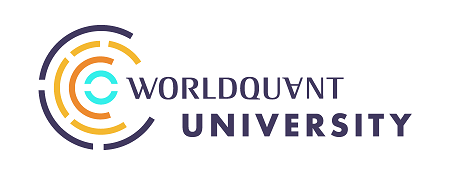



--------
# <center>Capstone Project - Group\#7107</center>
**Student : Huong Giang Ho**  

------
#####   The notebook includes the coding part used for the completion of the Capstone Project regarding the target variable - BTC.

1.   Data Collection
2.   Data Pre-Processing
3.   Bayesian Hyperparameter-Tuning LSTM Model
4.   Bayesian Hyperparameter-Tuning BiLSTM Model
5.   Result - LSTM vs. BiLSTM
6.   Discussion - Strategy vs. Benchmark

-----


Running the below codes to upload:

1. functions.py,
2. XGBRegressor_BTC.json,
3. bayesian_bilstm_model_BTC.keras,
4. bayesian_lstm_btc.keras.

They can be fetched in the folder "Trained Models" attached in the code submission.

In [ ]:
from google.colab import files
upload_1 = files.upload()
upload_2 = files.upload()
upload_3 = files.upload()
upload_4 = files.upload()

Saving functions.py to functions.py


Saving bayesian_bilstm_model_btc.keras to bayesian_bilstm_model_btc.keras


Saving bayesian_lstm_btc.keras to bayesian_lstm_btc.keras


Saving XGBRegressor_BTC.json to XGBRegressor_BTC.json


In [1]:
# Import libraries
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install("keras_tuner")
install("scikeras")
install("pandas_ta")
install("fredapi")
install("hyperopt")
install('quantstats')

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np
from numpy import sort
import yfinance as yf
import tensorflow as tf
from functions import *
import quantstats as qs

SEED = 123
DATA_SPLIT_PCT = 0.2

# Set the random seed for reproducibility
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1. DATA COLLECTION



## 1a. Historical Price Data

In [2]:
# Import Close Price, Volume, Open Price, High Price, Low Price
## Fetch BTC stock data
symbols = ['BTC-USD']
start_date = '2017-01-01'
end_date = '2024-08-01'
price_data = download_yahoo_finance(symbols,start_date=start_date,end_date=end_date)
price_data = price_data[['Open', 'High', 'Low', 'Close', 'Volume']]
price_data['Volume'] = price_data['Volume'].astype(float)
price_data = price_data.reset_index()

## Clean the data
## Remove the second column header
price_data.columns = price_data.columns.droplevel(1)
price_data.columns.name = None
## Reset the index if it's part of the problem
price_data = price_data.reset_index(drop=True)
price_data = price_data.set_index('Date')
## Clean index
price_data.index = price_data.index.tz_localize(None)

## Calculate perchange change for lag 1
price_data = lag_data(price_data)
price_data.head()

[*********************100%***********************]  1 of 1 completed


Open         High          Low        Close       Volume  \
Date                                                                          
2017-01-01   963.658020  1003.080017   958.698975   998.325012  147775008.0   
2017-01-02   998.617004  1031.390015   996.702026  1021.750000  222184992.0   
2017-01-03  1021.599976  1044.079956  1021.599976  1043.839966  185168000.0   
2017-01-04  1044.400024  1159.420044  1044.400024  1154.729980  344945984.0   
2017-01-05  1156.729980  1191.099976   910.416992  1013.380005  510199008.0   

            Open_lag1  High_lag1  Low_lag1  Close_lag1  Volume_lag1  
Date                                                                 
2017-01-01        NaN        NaN       NaN         NaN          NaN  
2017-01-02   0.036277   0.028223  0.039640    0.023464     0.503536  
2017-01-03   0.023015   0.012304  0.024980    0.021620    -0.166604  
2017-01-04   0.022318   0.110471  0.022318    0.106233     0.862881  
2017-01-05   0.107555   0.027324 -0.128287   -0.122410     0.479069

## 1b. Technical Indicators

In [3]:
price_data = calculate_indicators(price_data)
price_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2770 entries, 2017-01-01 to 2024-08-01
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            2770 non-null   float64
 1   High            2770 non-null   float64
 2   Low             2770 non-null   float64
 3   Close           2770 non-null   float64
 4   Volume          2770 non-null   float64
 5   Open_lag1       2769 non-null   float64
 6   High_lag1       2769 non-null   float64
 7   Low_lag1        2769 non-null   float64
 8   Close_lag1      2769 non-null   float64
 9   Volume_lag1     2769 non-null   float64
 10  Return_lag10    2760 non-null   float64
 11  RSI_14          2756 non-null   float64
 12  RSI_6           2764 non-null   float64
 13  RSI_5           2765 non-null   float64
 14  %K              2755 non-null   float64
 15  %D              2753 non-null   float64
 16  SMA5            2766 non-null   float64
 17  SMA10          

## 1c. Macroeconomic Data


In [4]:
## Fetch macroeconomic data
symbols = ['INR=X', 'CNY=X', 'BRL=X', 'VND=X', 'CL=F', 'GC=F', 'SI=F', '^GSPC', '^TNX', '^FVX']
macro_data = download_yahoo_finance(symbols, start_date, end_date)['Close']

## Convert both indexes to tz-aware DatetimeIndex
macro_data.index = macro_data.index.tz_localize(None)

## Rename
macro_data.rename(columns={
    'INR=X': 'USD/INR',
    'CNY=X': 'USD/CNY',
    'BRL=X': 'USD/BRL',
    'VND=X': 'USD/VND',
    'CL=F': 'Crude_Oil',
    'GC=F': 'Gold',
    '^GSPC': 'S&P500',
    'SI=F': 'Silver',
    '^FVX': '10Y_TB',
    '^TNX': '5Y_TB',}, inplace=True)

[*********************100%***********************]  10 of 10 completed


In [5]:
macro_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1902 entries, 2017-01-03 to 2024-08-01
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   USD/BRL    1902 non-null   float64
 1   Crude_Oil  1902 non-null   float64
 2   USD/CNY    1902 non-null   float64
 3   Gold       1902 non-null   float64
 4   USD/INR    1902 non-null   float64
 5   Silver     1902 non-null   float64
 6   USD/VND    1902 non-null   float64
 7   10Y_TB     1902 non-null   float64
 8   S&P500     1902 non-null   float64
 9   5Y_TB      1902 non-null   float64
dtypes: float64(10)
memory usage: 163.5 KB


# 2. DATA PRE-PROCESSING

## 2a. Data Cleaning

In [6]:
# Merge all data
btc_data = pd.concat([price_data, macro_data], axis=1, join="inner")
btc_data = btc_data.dropna()
btc_data.head()

Open         High          Low        Close       Volume  \
Date                                                                          
2017-02-03  1011.460022  1033.869995  1008.789978  1029.910034  201278000.0   
2017-02-06  1028.400024  1044.640015  1028.160034  1038.150024  111762000.0   
2017-02-07  1040.140015  1061.930054  1040.140015  1061.349976  146007008.0   
2017-02-08  1062.319946  1078.969971  1037.489990  1063.069946  201855008.0   
2017-02-09  1064.699951  1088.989990   953.343994   994.382996  407220000.0   

            Open_lag1  High_lag1  Low_lag1  Close_lag1  Volume_lag1  ...  \
Date                                                                 ...   
2017-02-03   0.021676   0.020079  0.026005    0.017899     0.380309  ...   
2017-02-06  -0.014489   0.000968  0.005663    0.010522    -0.021417  ...   
2017-02-07   0.011416   0.016551  0.011652    0.022347     0.306410  ...   
2017-02-08   0.021324   0.016046 -0.002548    0.001621     0.382502  ...   
2017-02-09   0.002240   0.009287 -0.081105   -0.064612     1.017389  ...   

            USD/BRL  Crude_Oil  USD/CNY         Gold    USD/INR     Silver  \
Date                                                                         
2017-02-03   3.1225  53.830002   6.8800  1218.500000  67.265602  17.452999   
2017-02-06   3.1195  53.009998   6.8722  1230.000000  67.157303  17.667000   
2017-02-07   3.1137  52.169998   6.8636  1234.199951  67.195297  17.733000   
2017-02-08   3.1167  52.340000   6.8845  1237.599976  67.340500  17.683001   
2017-02-09   3.1159  53.000000   6.8725  1235.099976  66.964302  17.719999   

            USD/VND  10Y_TB       S&P500  5Y_TB  
Date                                             
2017-02-03  22137.0   1.933  2297.419922  2.491  
2017-02-06  22196.0   1.854  2292.560059  2.413  
2017-02-07  22210.0   1.844  2293.080078  2.389  
2017-02-08  22183.0   1.816  2294.669922  2.351  
2017-02-09  22347.0   1.870  2307.870117  2.395  

[5 rows x 38 columns]

In [7]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1880 entries, 2017-02-03 to 2024-08-01
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Open            1880 non-null   float64
 1   High            1880 non-null   float64
 2   Low             1880 non-null   float64
 3   Close           1880 non-null   float64
 4   Volume          1880 non-null   float64
 5   Open_lag1       1880 non-null   float64
 6   High_lag1       1880 non-null   float64
 7   Low_lag1        1880 non-null   float64
 8   Close_lag1      1880 non-null   float64
 9   Volume_lag1     1880 non-null   float64
 10  Return_lag10    1880 non-null   float64
 11  RSI_14          1880 non-null   float64
 12  RSI_6           1880 non-null   float64
 13  RSI_5           1880 non-null   float64
 14  %K              1880 non-null   float64
 15  %D              1880 non-null   float64
 16  SMA5            1880 non-null   float64
 17  SMA10          

**Data Visualization**

<Figure size 1600x1000 with 0 Axes>

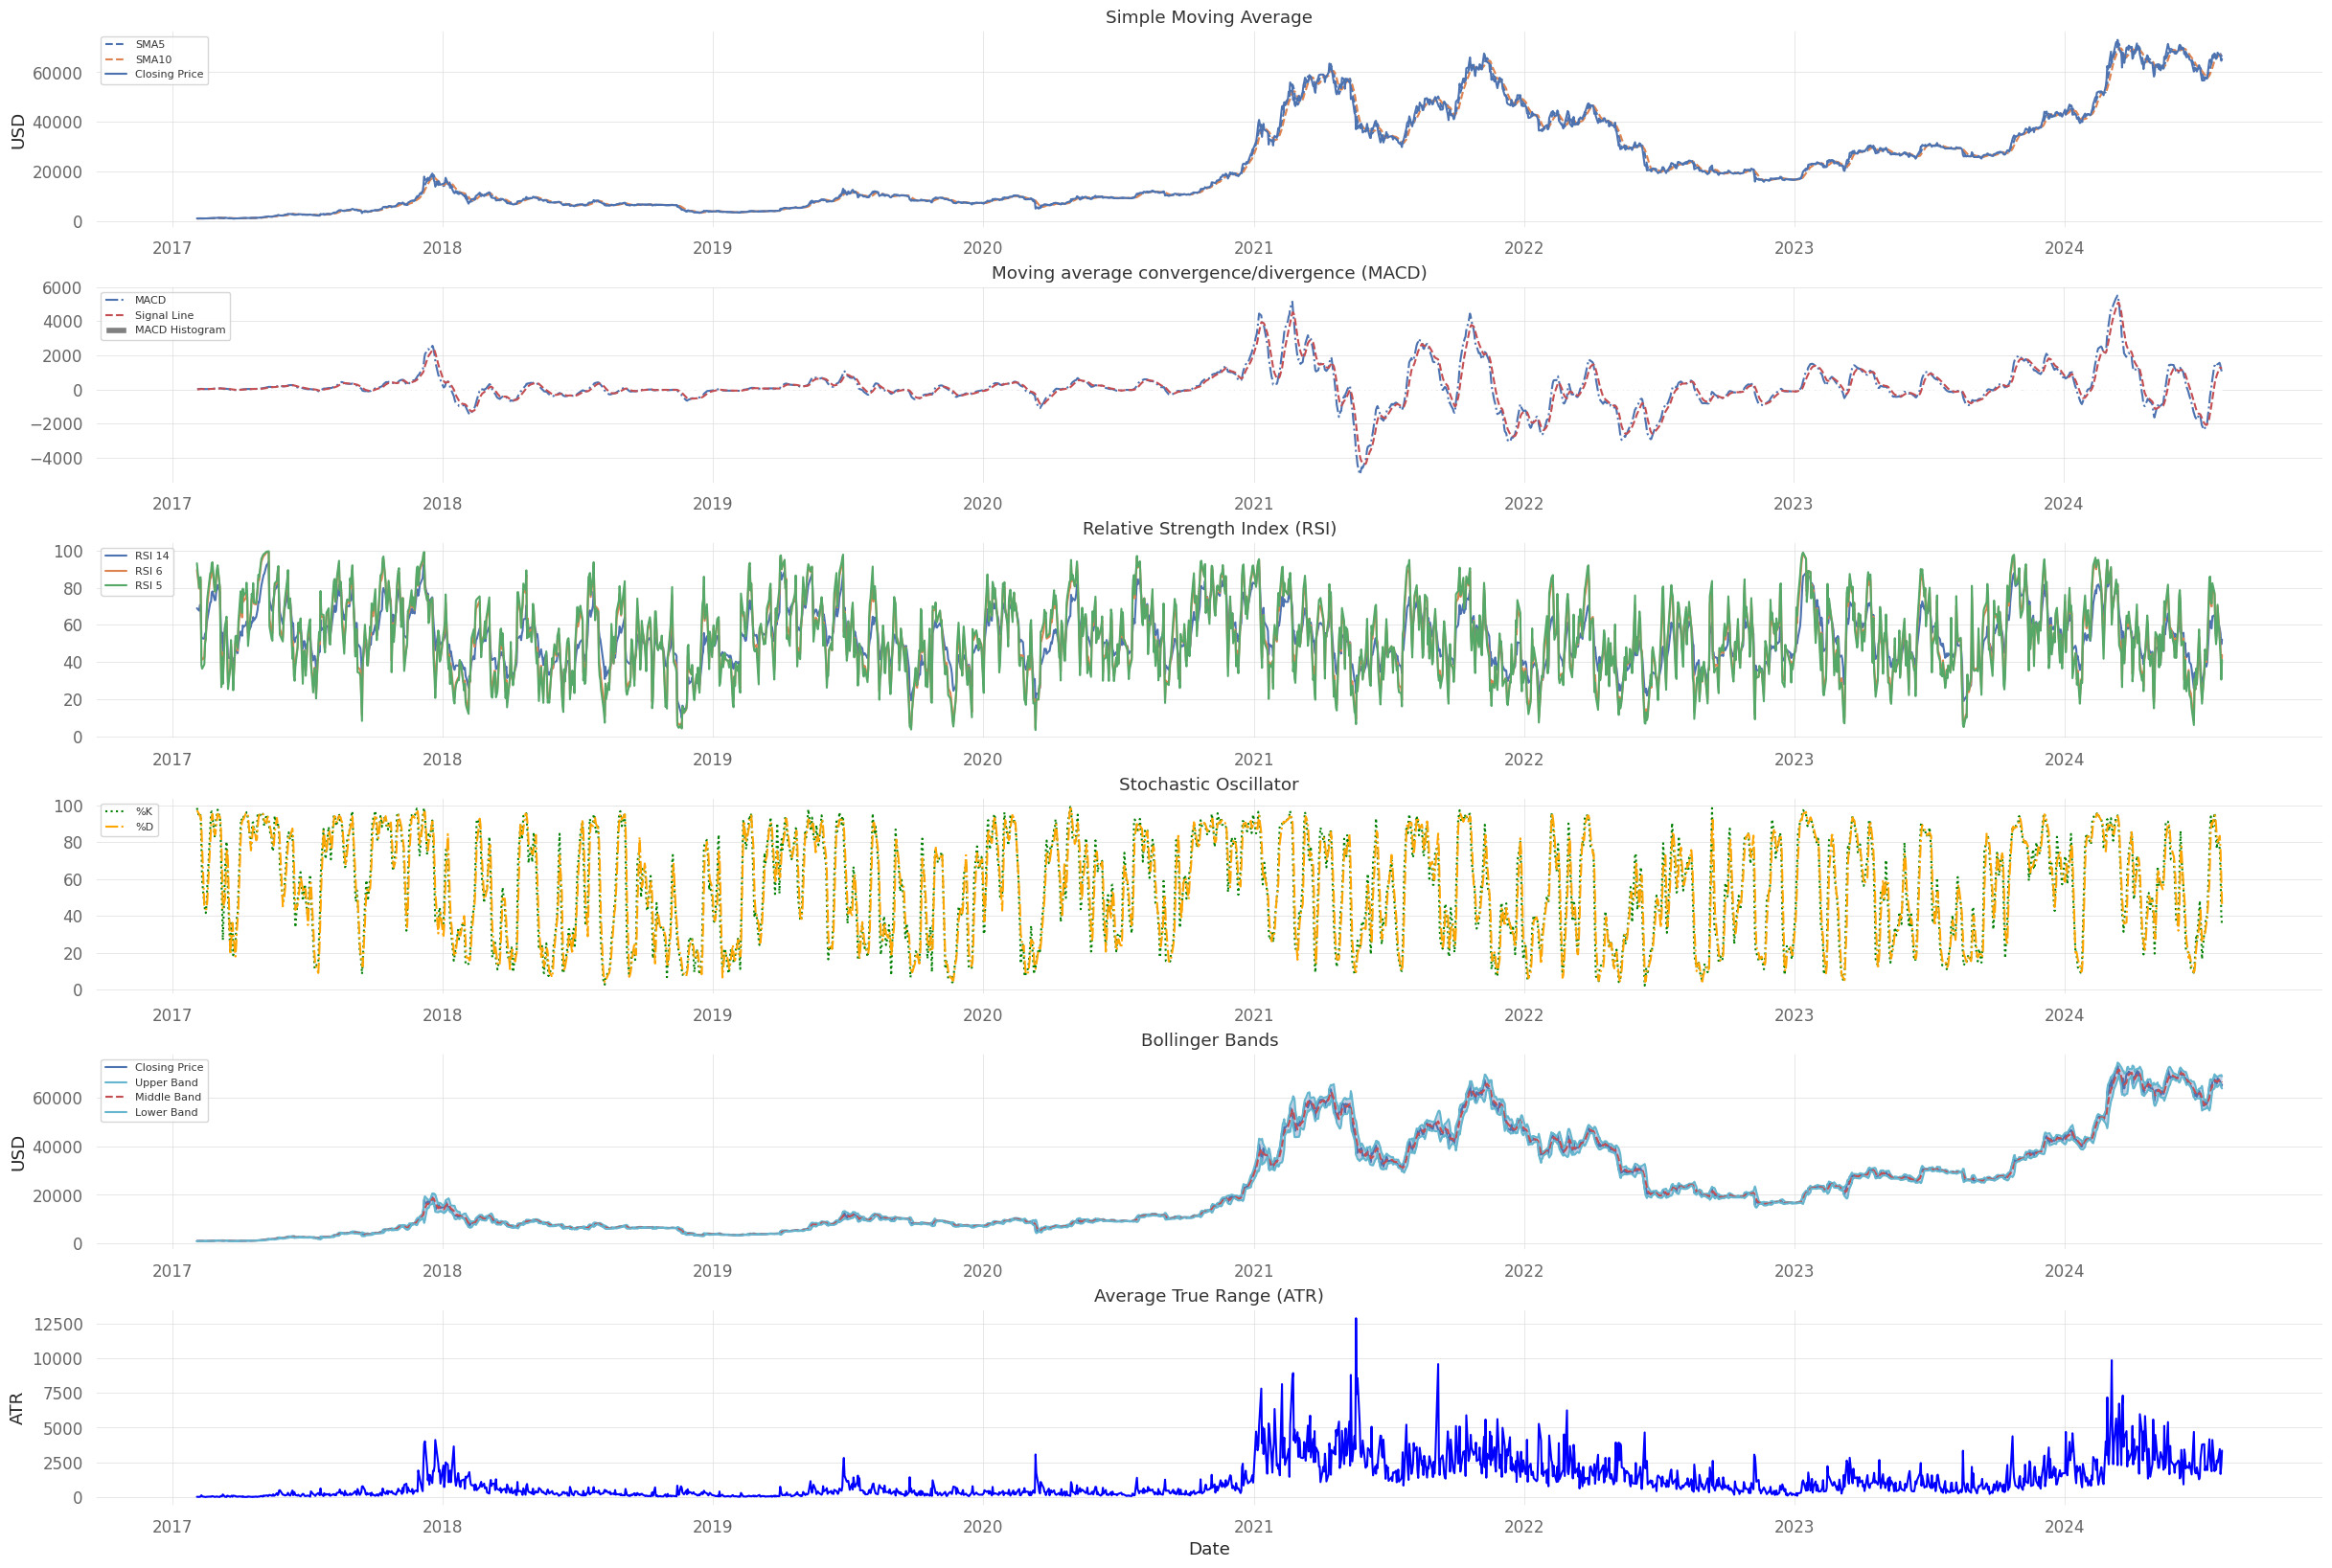

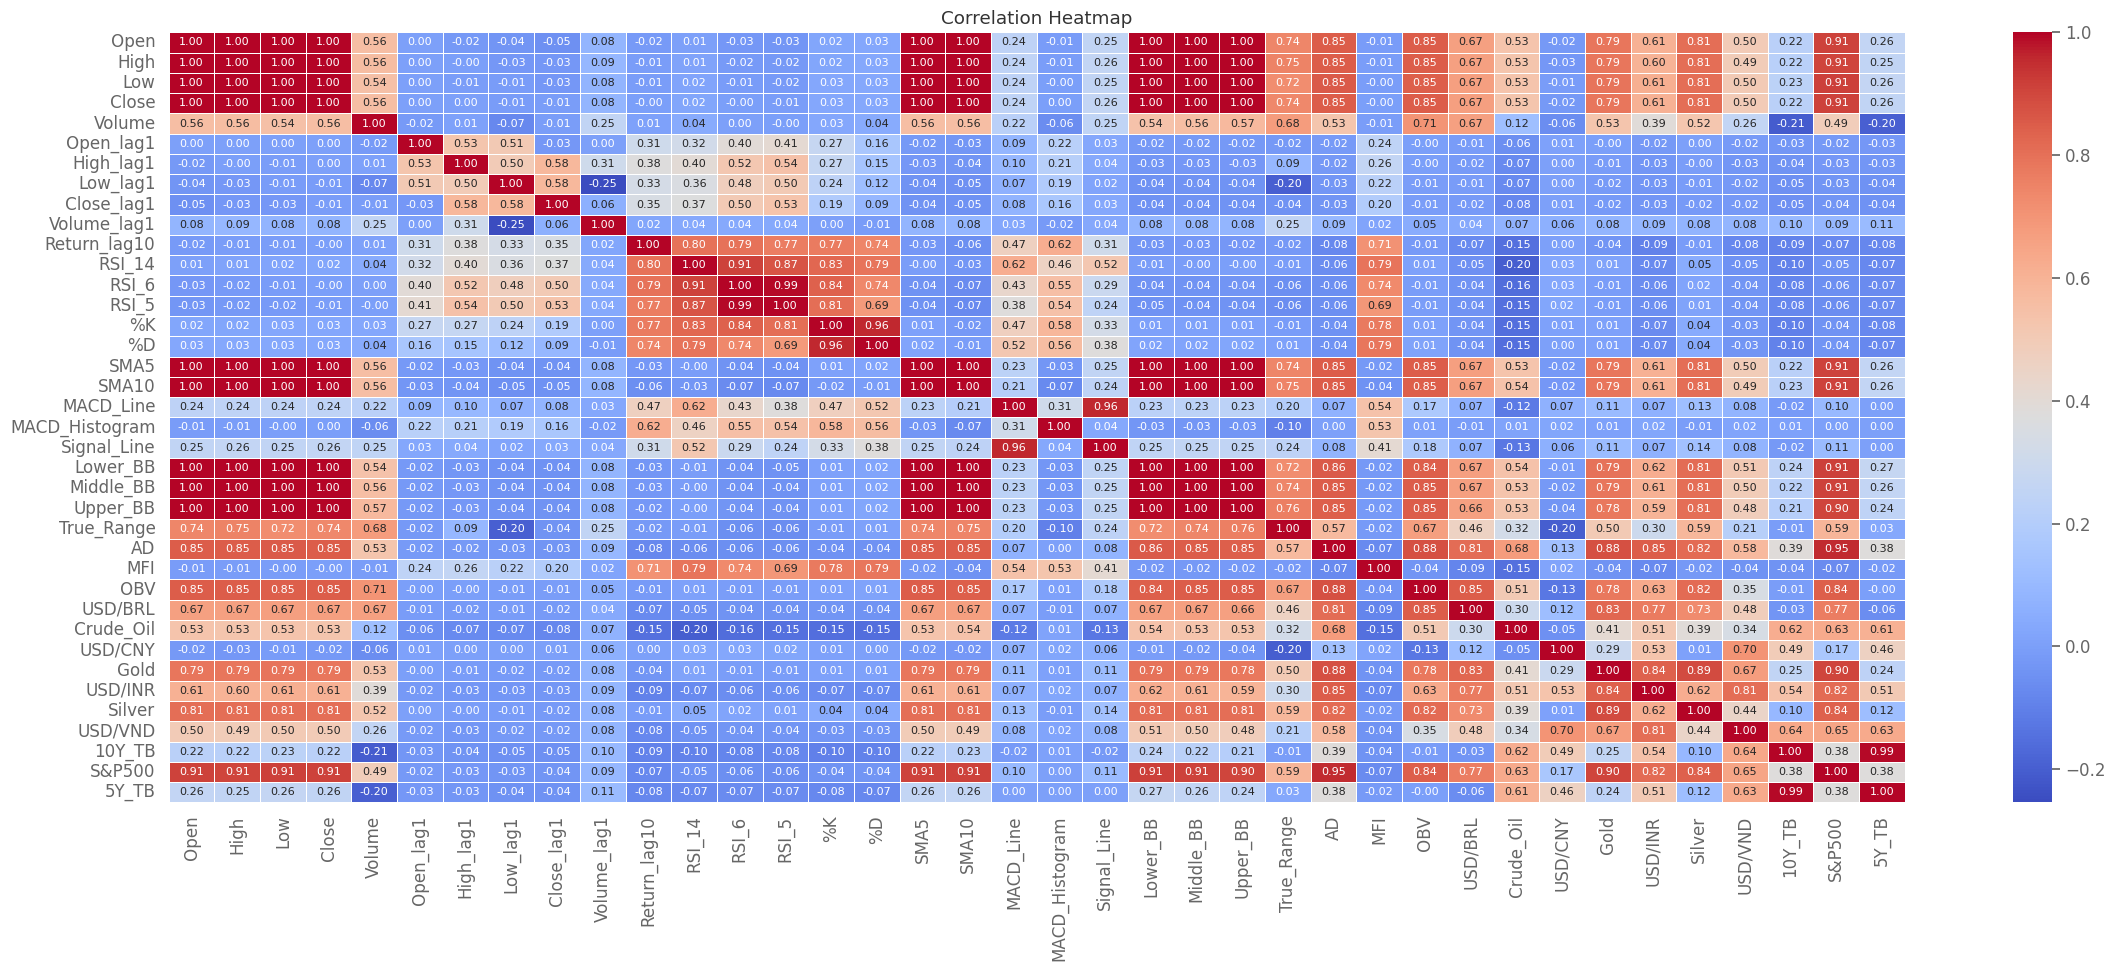

In [8]:
# Plot technical indicators
plot_technical_indicators(btc_data, 1880)

# Plot correlation among variables
plt.figure(figsize=(28, 10))
heatmap = sns.heatmap(btc_data.corr(), annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, annot_kws={"size": 8})
heatmap.set_title('Correlation Heatmap');

High Correlation with Close:


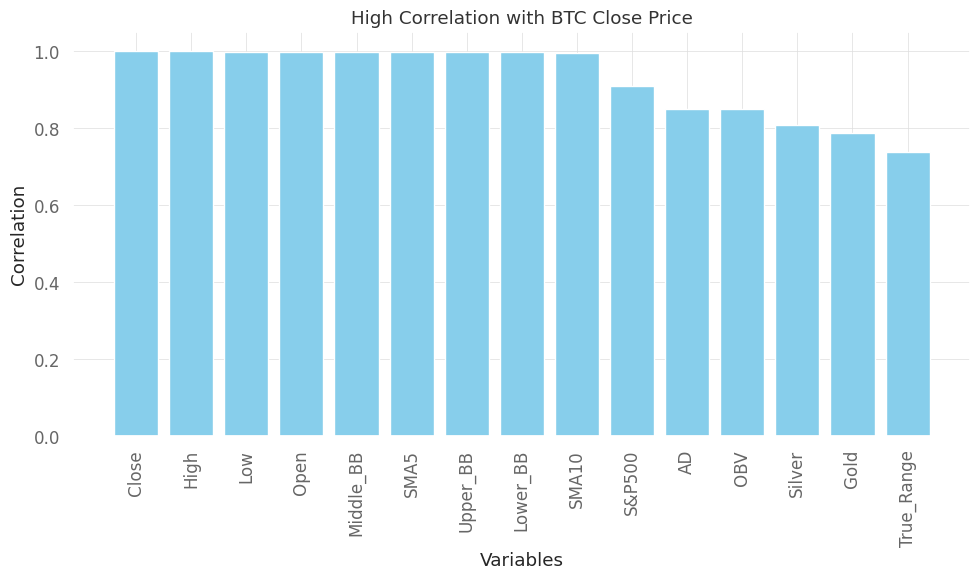

In [9]:
high_correlation_df = high_correlation(btc_data, 'Close', threshold=0.7)

# Plot the high correlation variables with 'Close' using a bar plot
plt.bar(high_correlation_df.index, high_correlation_df, color='skyblue')
plt.title('High Correlation with BTC Close Price')
plt.ylabel('Correlation')
plt.xlabel('Variables')
plt.xticks(rotation=90)

# Save the plot as an image
plt.tight_layout()
plt.savefig('high_correlation_barplot.png', dpi=300)
plt.show()

## 2b. Feature Selection: XGBRegressor

In [10]:
# Load the data
target_column = 'Close'
X_xgboost = btc_data.loc[:, btc_data.columns != target_column]
y_xgboost = btc_data[target_column].values

# Splitting
X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(X_xgboost, y_xgboost, test_size = DATA_SPLIT_PCT, shuffle = False)

# Scale the data
scaler_xgboost = MinMaxScaler(feature_range=(0, 1))
X_train_scaled_xgboost = scaler_xgboost.fit_transform(X_train_xgboost)
X_test_scaled_xgboost = scaler_xgboost.transform(X_test_xgboost)

The below code demonstrates the process of tuning and training XGBRegressor.

In [11]:
# Define the objective function
def objective(params):
    # Create XGBoost model with hyperparameters
    model = xg.XGBRegressor(
        objective='reg:squarederror',
        max_depth=int(params['max_depth']),
        n_estimators=int(params['n_estimators']),
        learning_rate=params['learning_rate'],
        reg_lambda=params['reg_lambda'],
        reg_alpha=params['reg_alpha'],
        random_state=SEED
    )

    # Train the model
    model.fit(X_train_scaled_xgboost, y_train_xgboost)

    # Make predictions
    predictions = model.predict(X_test_scaled_xgboost)

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test_xgboost, predictions))

    return {'loss': rmse, 'status': STATUS_OK}

# Define the hyperparameter space
space = {
    'max_depth': hp.uniform('max_depth', 0, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 500, 1),
    'learning_rate': hp.uniform('learning_rate', 0.1, 1),
    'reg_lambda': hp.uniform('reg_lambda', 1, 2),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1)
}

# Create Trials object to store results
trials = Trials()

# Run Bayesian optimization
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,  # Number of iterations
    trials=trials
)

print("Best hyperparameters:", best)

# Apply best parameters to train final model
best_params = {
    'max_depth': int(best['max_depth']),
    'n_estimators': int(best['n_estimators']),
    'learning_rate': best['learning_rate'],
    'reg_lambda': best['reg_lambda'],
    'reg_alpha': best['reg_alpha']}

# Create final XGBoost model with best hyperparameters
final_model = xg.XGBRegressor(
    objective='reg:squarederror',
    **best_params,
    random_state=SEED
)

# Train the model
final_model.fit(X_train_scaled_xgboost, y_train_xgboost)

100%|██████████| 100/100 [15:05<00:00,  9.05s/trial, best loss: 1818.1124715450526]
Best hyperparameters: {'learning_rate': 0.21693348211013613, 'max_depth': 0.6577238623598901, 'n_estimators': 244.0, 'reg_alpha': 0.1757686207963467, 'reg_lambda': 1.4267188415448828}


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.21693348211013613,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=0, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=244, n_jobs=None,
             num_parallel_tree=None, random_state=123, ...)

For consistent result, the tuned hyperparameters are applied, then being fitted
to the model. Alternatively, the best hyperparameters are applied, then loading the trained models and use it.

In [12]:
# Apply best parameters to train final model
best_params = {
    'max_depth': int(0.6577238623598901),
    'n_estimators': int(244.0),
    'learning_rate': 0.21693348211013613,
    'reg_lambda': 1.4267188415448828,
    'reg_alpha': 0.1757686207963467}

# Create final XGBoost model with best hyperparameters
final_model = xg.XGBRegressor(
    objective='reg:squarederror',
    **best_params,
    random_state=SEED
)

In [15]:
# Save the model
#final_model.save_model('XGBRegressor_BTC.json')

# Upload the saved model
loaded_model = xg.XGBRegressor()
final_model.load_model('XGBRegressor_BTC.json')

In [16]:
# Prediction
y_pred_xgboost = final_model.predict(X_test_scaled_xgboost)
predictions = [round(value) for value in y_pred_xgboost]

# RMSE computation
rmse = np.sqrt(mean_squared_error(y_test_xgboost, predictions))
print("RMSE: % f" %(rmse))

rmses = []
num_features = []

# Fit model using each importancce as a threshold
thresholds = sort(final_model.feature_importances_)
for thresh in thresholds:
  selection = SelectFromModel(final_model, threshold=thresh, prefit = True)
  select_X_train = selection.transform(X_train_scaled_xgboost)

  # train model
  selection_model = xg.XGBRegressor(
    objective='reg:squarederror',
    **best_params,
    random_state=SEED)
  selection_model.fit(select_X_train, y_train_xgboost)

  # evaluate model
  select_X_test = selection.transform(X_test_scaled_xgboost)
  predictions = selection_model.predict(select_X_test)
  rmse = np.sqrt(mean_squared_error(y_test_xgboost, predictions))
  rmses.append(rmse)
  num_features.append(select_X_train.shape[1])
  print("Thresh=%.3f, n=%d, RMSE: %f" %(thresh, select_X_train.shape[1], rmse))

RMSE:  1818.105933
Thresh=0.000, n=37, RMSE: 1818.112472
Thresh=0.000, n=36, RMSE: 1818.112472
Thresh=0.000, n=35, RMSE: 1835.894254
Thresh=0.000, n=34, RMSE: 1847.347553
Thresh=0.000, n=33, RMSE: 1868.557741
Thresh=0.000, n=32, RMSE: 1837.167488
Thresh=0.000, n=31, RMSE: 1923.416709
Thresh=0.000, n=30, RMSE: 1890.630426
Thresh=0.000, n=29, RMSE: 1891.208767
Thresh=0.000, n=28, RMSE: 1913.395480
Thresh=0.000, n=27, RMSE: 1899.743714
Thresh=0.000, n=26, RMSE: 1849.925704
Thresh=0.000, n=25, RMSE: 1883.845306
Thresh=0.000, n=24, RMSE: 1902.651086
Thresh=0.000, n=23, RMSE: 1900.871107
Thresh=0.000, n=22, RMSE: 1938.313098
Thresh=0.000, n=21, RMSE: 1839.590448
Thresh=0.000, n=20, RMSE: 1831.404675
Thresh=0.000, n=19, RMSE: 1746.850547
Thresh=0.000, n=18, RMSE: 1750.802717
Thresh=0.000, n=17, RMSE: 1754.277349
Thresh=0.000, n=16, RMSE: 1648.069071
Thresh=0.000, n=15, RMSE: 1660.059064
Thresh=0.000, n=14, RMSE: 1658.872959
Thresh=0.000, n=13, RMSE: 1567.097033
Thresh=0.000, n=12, RMSE: 1627.

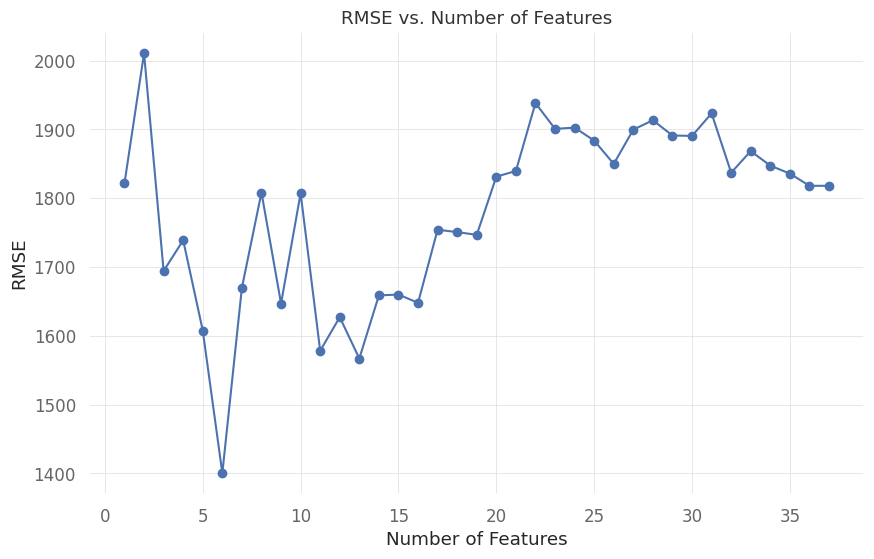

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(num_features, rmses, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of Features')
plt.show()

In [18]:
# Feature Importance
feature_importance_df = pd.DataFrame(final_model.feature_importances_, columns=['Importance'])
feature_importance_df['Feature'] = X_xgboost.columns

# Sort the DataFrame by 'Importance' in descending order
feature_importance_df.sort_values(by='Importance', ascending=True, inplace=True)
feature_importance_df

Importance         Feature
21    0.000000       Middle_BB
14    0.000002              %D
19    0.000003     Signal_Line
27    0.000003         USD/BRL
30    0.000004            Gold
8     0.000004     Volume_lag1
28    0.000004       Crude_Oil
36    0.000004           5Y_TB
17    0.000004       MACD_Line
25    0.000004             MFI
3     0.000005          Volume
33    0.000006         USD/VND
6     0.000006        Low_lag1
4     0.000006       Open_lag1
9     0.000006    Return_lag10
18    0.000007  MACD_Histogram
31    0.000007         USD/INR
34    0.000008          10Y_TB
35    0.000010          S&P500
13    0.000010              %K
5     0.000011       High_lag1
23    0.000011      True_Range
26    0.000018             OBV
20    0.000029        Lower_BB
12    0.000033           RSI_5
11    0.000058           RSI_6
32    0.000061          Silver
10    0.000070          RSI_14
29    0.000075         USD/CNY
24    0.000095              AD
16    0.000101           SMA10
7     0.000251      Close_lag1
22    0.002202        Upper_BB
15    0.095484            SMA5
1     0.128410            High
0     0.324447            Open
2     0.448541             Low



- We select the set of features with the lowest RMSE.



In [19]:
column_to_select = ['Low', 'Open', 'High', 'SMA5', 'Upper_BB', 'Close_lag1','Close']
btc_data_1 = btc_data[column_to_select].copy()
btc_data_1 = btc_data_1.dropna()
btc_data_1.tail()

Low          Open          High          SMA5  \
Date                                                                 
2024-07-26  65743.765625  65771.812500  68207.601562  66514.868750   
2024-07-29  66532.593750  68259.054688  69987.539062  67315.681250   
2024-07-30  65323.191406  66819.054688  66987.671875  67400.439062   
2024-07-31  64532.046875  66201.273438  66810.210938  66741.876562   
2024-08-01  62248.941406  64625.839844  65593.242188  66250.709375   

                Upper_BB  Close_lag1         Close  
Date                                                
2024-07-26  68572.562213    0.032456  67912.062500  
2024-07-29  69126.738027   -0.021038  66819.914062  
2024-07-30  68933.964545   -0.009262  66201.015625  
2024-07-31  69310.044273   -0.023893  64619.250000  
2024-08-01  68749.765833    0.011425  65357.500000

In [20]:
btc_data_1.describe()

Low          Open          High          SMA5      Upper_BB  \
count   1880.000000   1880.000000   1880.000000   1880.000000   1880.000000   
mean   22057.044252  22672.722521  23240.651874  22640.301898  23830.858552   
std    18621.134185  19164.584948  19638.213516  19113.412131  20100.632245   
min      934.357971    972.054993    998.905029    984.303613   1006.958226   
25%     7161.882324   7318.923706   7493.791260   7282.591748   7630.498903   
50%    15566.909180  16179.544434  16620.754883  16314.634180  16950.755153   
75%    35074.913086  36512.137695  37569.506836  36280.638672  38075.461068   
max    71334.093750  73079.375000  73750.070312  71497.812500  74406.519957   

        Close_lag1         Close  
count  1880.000000   1880.000000  
mean      0.002589  22689.518015  
std       0.041098  19159.540032  
min      -0.371695    937.520020  
25%      -0.015976   7321.751221  
50%       0.001095  16297.076172  
75%       0.021270  36611.094727  
max       0.252472  73083.500000

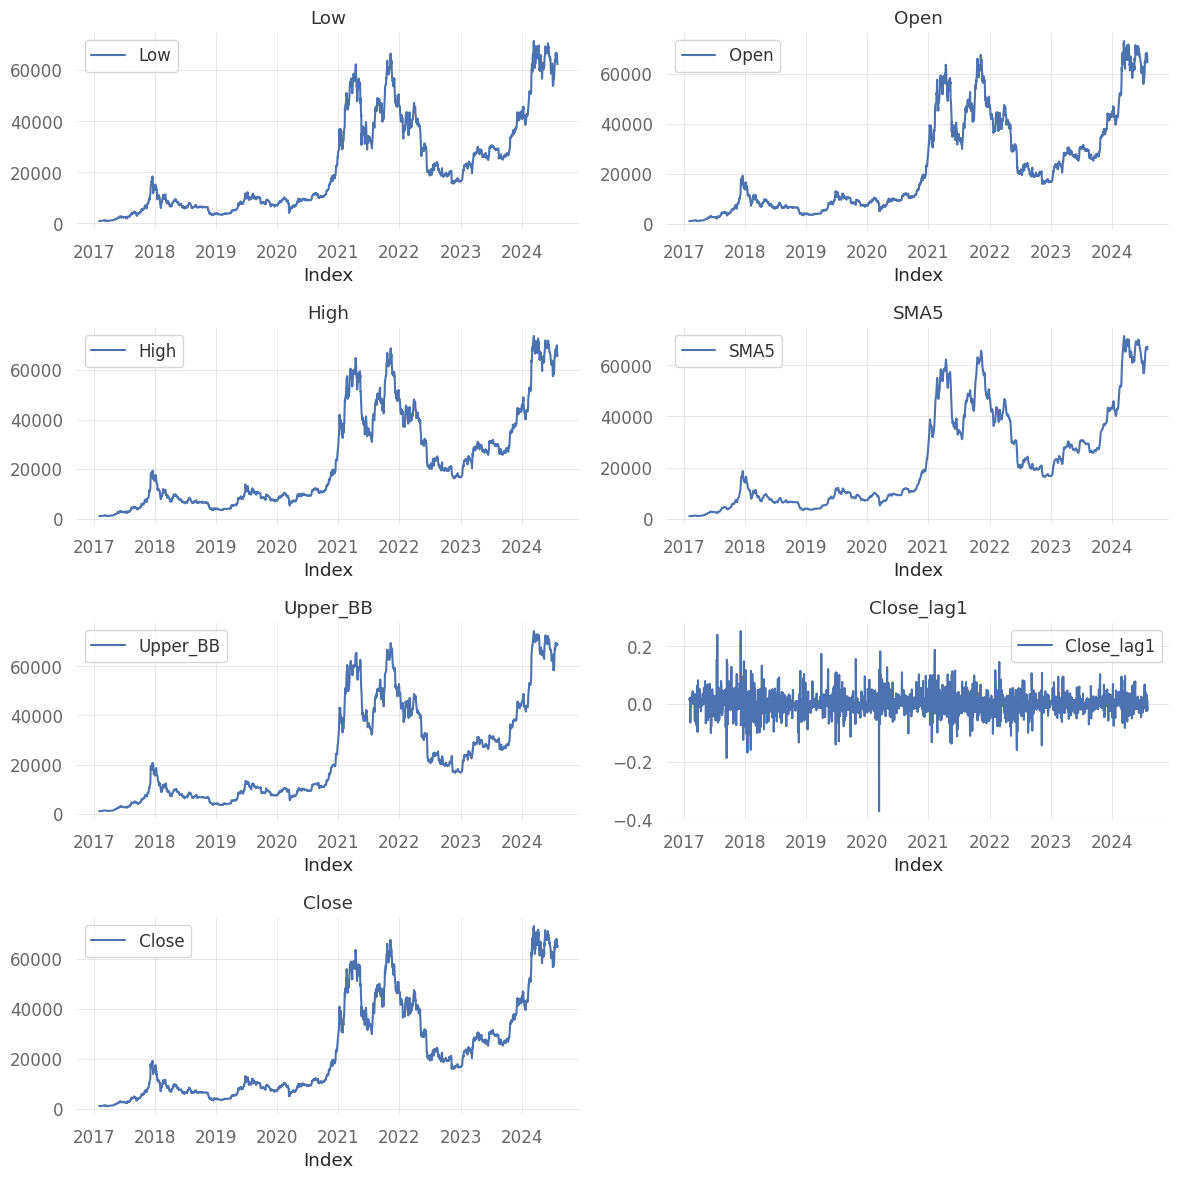

In [21]:
# Visualization
df_to_plot = btc_data_1[column_to_select].copy()
plot_columns(df_to_plot)

## 2c. Data Temporalization, Data Splitting and Data Scaling

In [57]:
# Temporalizing the Data: samples x lookback x features
target_column = 'Close'
lookback = 5

# Extract the features and target
input_X, input_y, n_features = input(btc_data_1, target_column)
n_features = input_X.shape[1]

# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)
print('The shape of X:', X.shape)
print('The shape of y:', y.shape)

# Split into train, valid, and test
X_train, X_test, X_valid, y_train, y_test, y_valid = split_data(X, y, DATA_SPLIT_PCT, SEED)

# Reshape
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_test = X_test.reshape(X_test.shape[0], lookback, n_features)
TIMESTEPS = X_train.shape[1] # equal to the lookback

print('The shape of train data:', X_train.shape, y_train.shape)
print('The shape of valid data:', X_valid.shape, y_valid.shape)
print('The shape of test data:', X_test.shape, y_test.shape)
print('Lookback:', TIMESTEPS)
print('Number of features:', n_features)

# Scale the training data.
scaler_X = MinMaxScaler(feature_range=(0, 1)).fit(flatten(X_train))
X_train_scaled = scale(X_train, scaler_X)
X_valid_scaled = scale(X_valid, scaler_X)
X_test_scaled = scale(X_test, scaler_X)

The shape of X: (1874, 5, 6)
The shape of y: (1874,)
The shape of train data: (1199, 5, 6) (1199,)
The shape of valid data: (300, 5, 6) (300,)
The shape of test data: (375, 5, 6) (375,)
Lookback: 5
Number of features: 6


**The sections 3 and 4 present how LSTM and BiLSTM models are trained. The best model performance is saved, then reloading to make future predictions. Similarly, the same process is applied to BiLSTM.**

# 3. BAYESIAN HYPER-PARAMETER TUNING LSTM MODEL



The below code demonstrates the process of training LSTM model. Specifically, after defining input shape and output units, LSTM model is initialized, then its hyperparameters are tunned using Bayesian optimization. Finally, the best hyperparameters are applied to fit the LSTM model.

In [23]:
# Define shape and output
input_shape = (X_train.shape[1], X_train.shape[2])
output_units = y_train.shape[1] if len(y_train.shape) > 1 else 1  # Adjust based on target shape

# Initialize Bayesian-LSTM
lstm_hypermodel = LSTMHyperModel(input_shape=input_shape, output_units=output_units)

# Tune LSTM hyperparameters with Bayesian Optimization
model_bayesian_lstm = bayesian_opt_tuner(lstm_hypermodel, X_train_scaled, y_train, X_valid_scaled, y_valid)

# Fit the model
history_bayesian_lstm = fit_model(model_bayesian_lstm, X_train_scaled, y_train, X_valid_scaled, y_valid)

The best hyperparameters are 
 {'lstm_layer_1': 35, 'dropout_1': 0.2, 'lstm_layer_2': 51, 'dropout_2': 0.2, 'learning_rate': 0.001}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 5, 35)               │           5,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 35)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 5, 51)               │          17,748 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 255)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 255)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             256 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,884 (93.30 KB)

 Trainable params: 23,884 (93.30 KB)

 Non-trainable params: 0 (0.00 B)

None


For consistent result, please load the trained model attached in the code submission.

In [26]:
# Step by step to reload the trained model
# Step 1: Save the trained model
#model_bayesian_lstm.save('bayesian_lstm_btc.keras')

# Step 2: Load the model
model_bayesian_lstm = load_model('bayesian_lstm_btc.keras')

# Step 3: Fit the model
history_bayesian_lstm = fit_model(model_bayesian_lstm, X_train_scaled, y_train, X_valid_scaled, y_valid)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


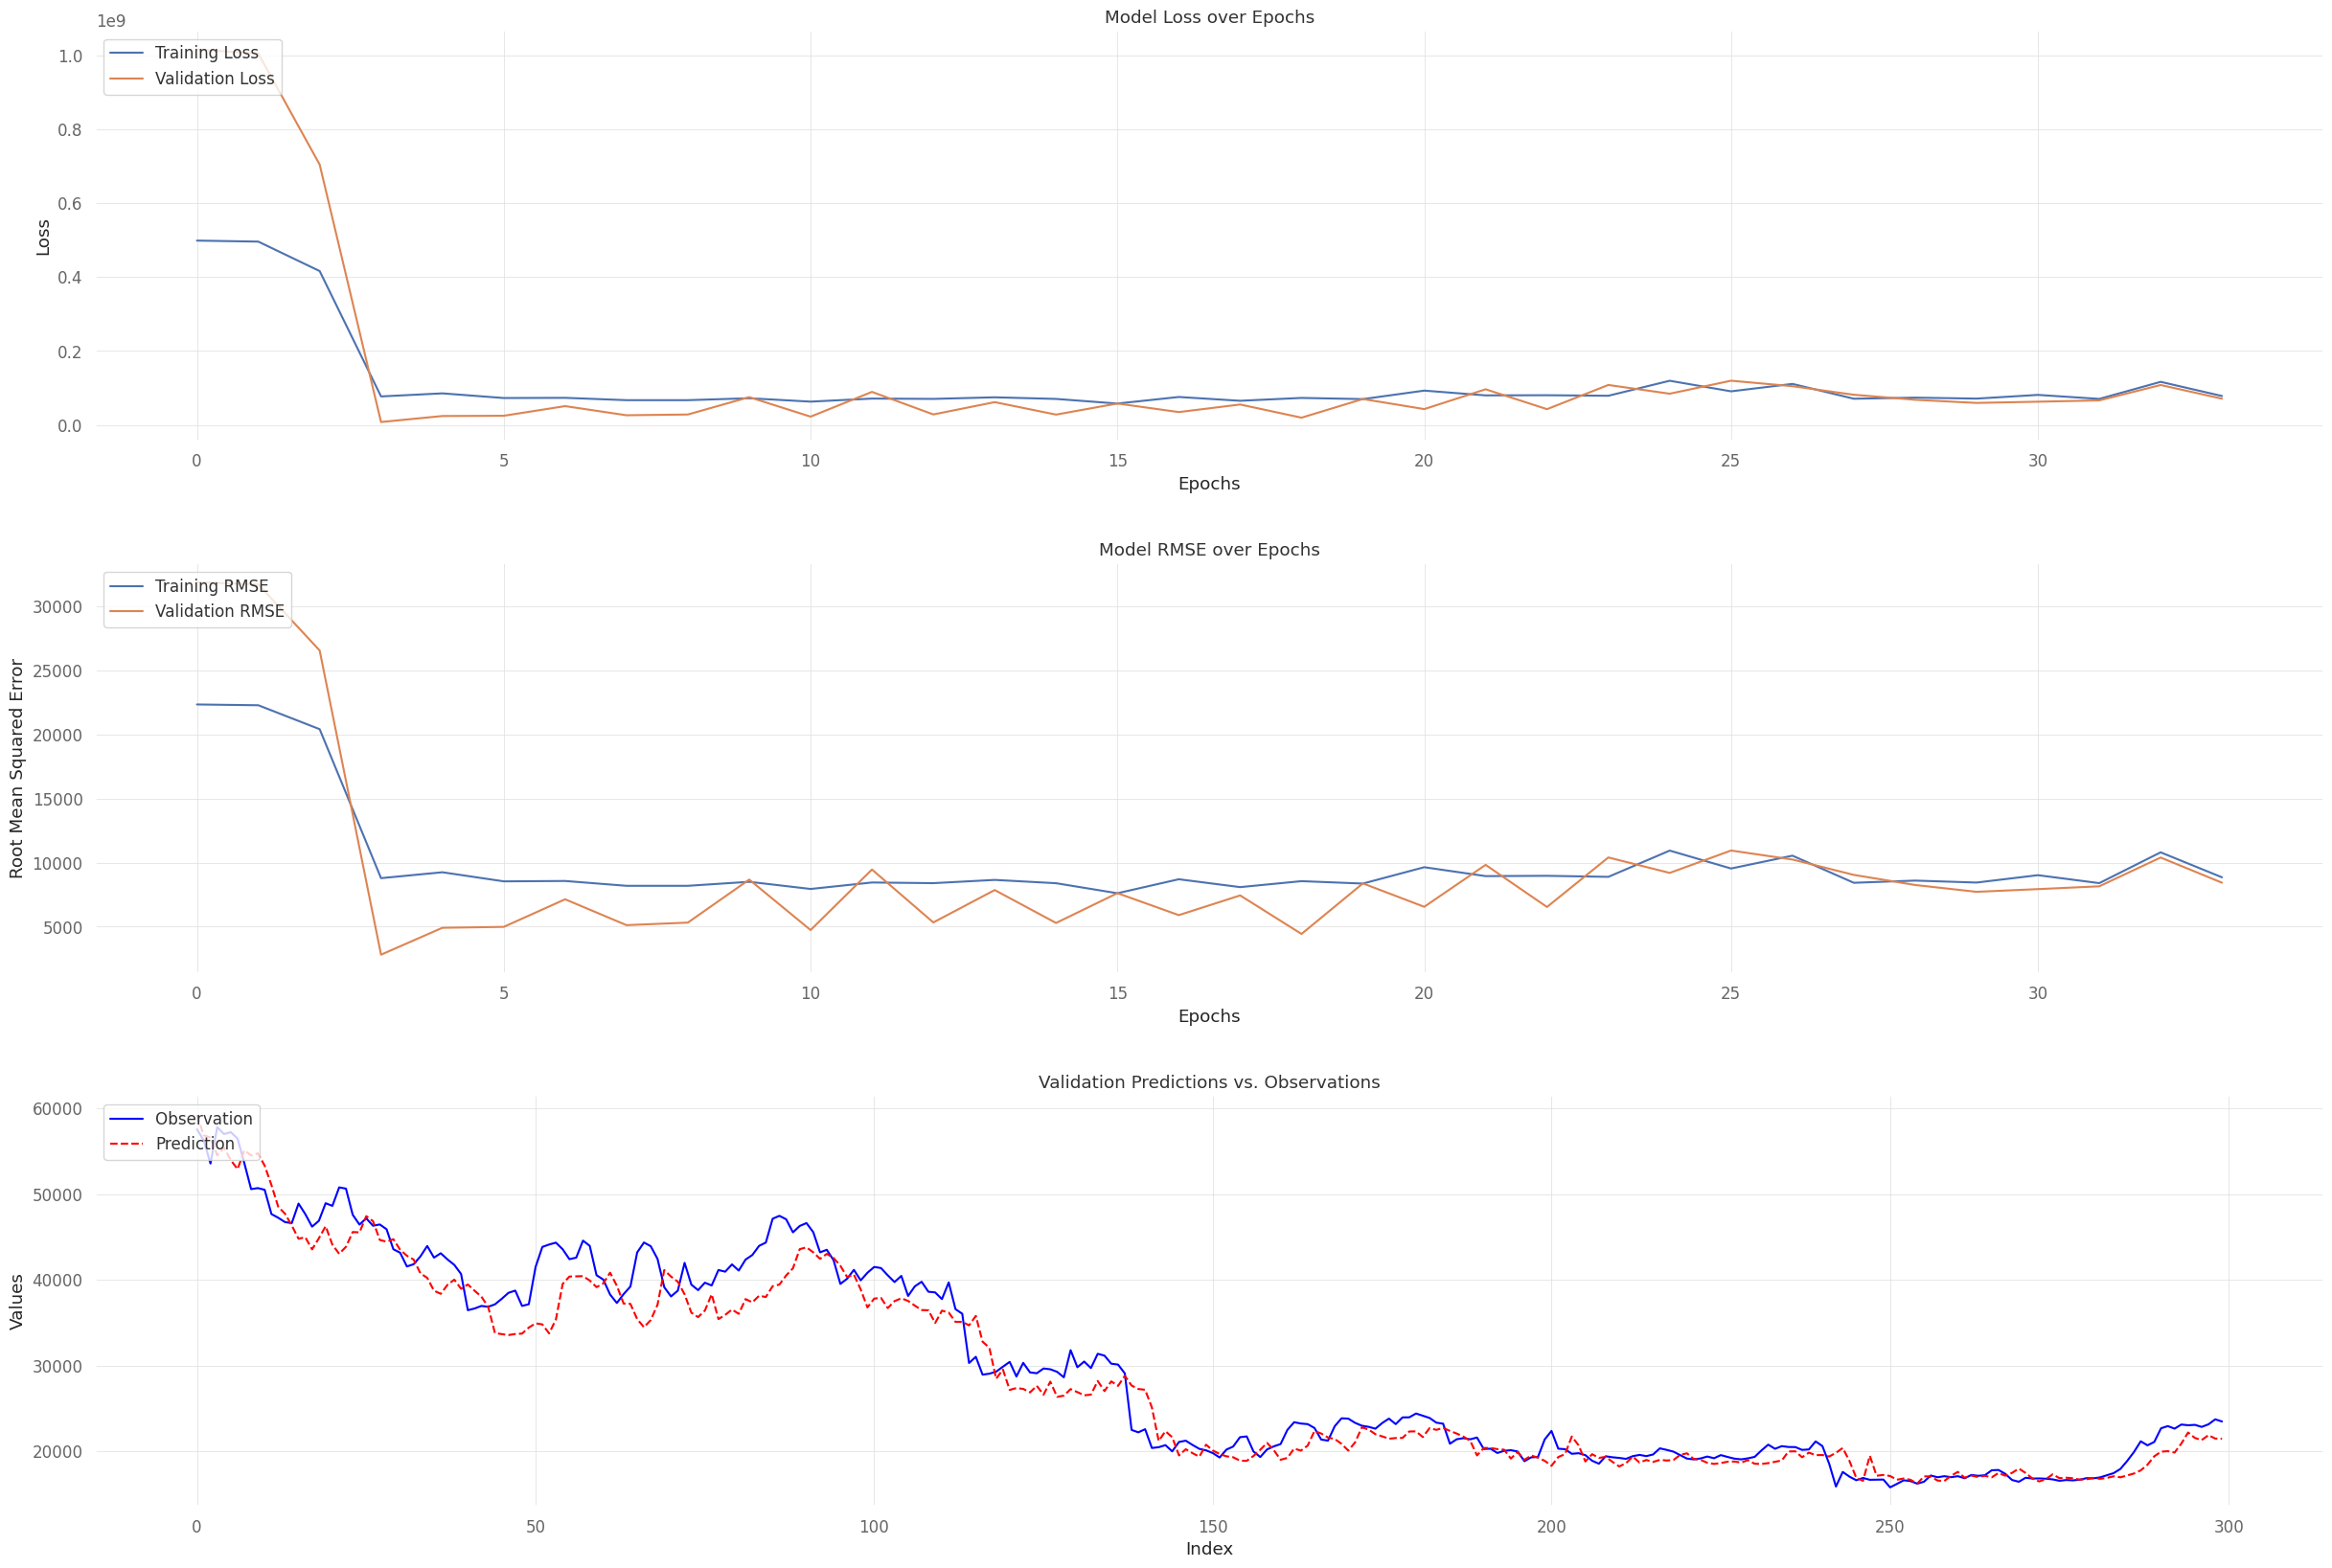

In [24]:
# Inspect performance on validation data
val_inspection(history_bayesian_lstm, model_bayesian_lstm, X_valid_scaled, y_valid)

In [25]:
# Check performance metrics
train_predict_bayesian_lstm = model_bayesian_lstm.predict(X_train_scaled)
valid_predict_bayesian_lstm = model_bayesian_lstm.predict(X_valid_scaled)
test_predict_bayesian_lstm = model_bayesian_lstm.predict(X_test_scaled)

bayesian_lstm_train_mae, bayesian_lstm_train_rmse = evaluate_prediction(train_predict_bayesian_lstm, y_train, 'Evaluation result from Bayesian-Hyperparameter Tuning LSTM on train data')
bayesian_lstm_valid_mae, bayesian_lstm_valid_rmse = evaluate_prediction(valid_predict_bayesian_lstm, y_valid, 'Evaluation result from Bayesian-Hyperparameter Tuning LSTM on valid data')
bayesian_lstm_test_mae, bayesian_lstm_test_rmse = evaluate_prediction(test_predict_bayesian_lstm, y_test, 'Evaluation result from Bayesian-Hyperparameter Tuning LSTM on test data')

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation result from Bayesian-Hyperparameter Tuning LSTM on train data:
Mean Absolute Error: 14655.8387
Root Mean Square Error: 21588.2962

Evaluation result from Bayesian-Hyperparameter Tuning LSTM on valid data:
Mean Absolute Error: 12558.1789
Root Mean Square Error: 16073.1148

Evaluation result from Bayesian-Hyperparameter Tuning LSTM on test data:
Mean Absolute Error: 18640.1144
Root Mean Square Error: 24022.5138



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Out-of-sample R-squared: 0.94
Bayesian-Hyperparameter Tuning LSTM:
Mean Absolute Error: 18640.1144
Root Mean Square Error: 24022.5138



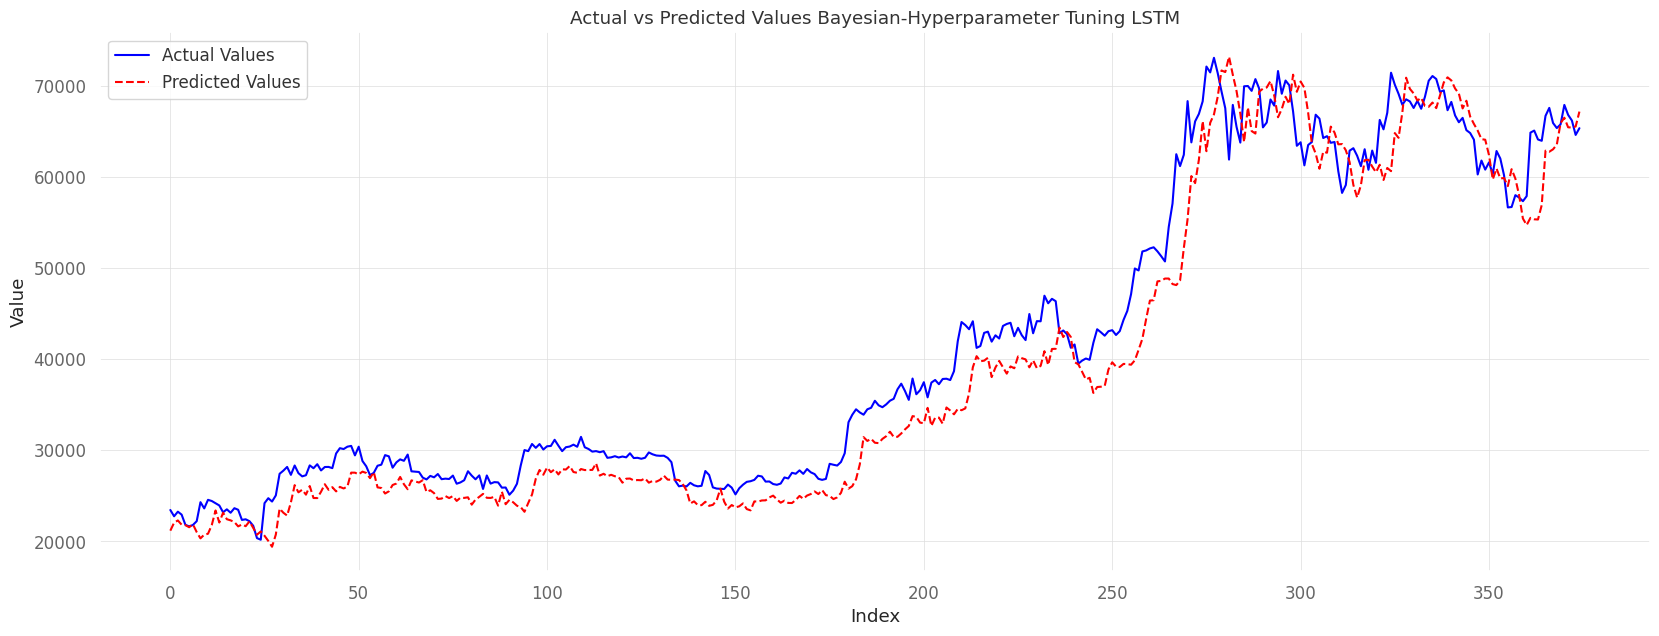

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


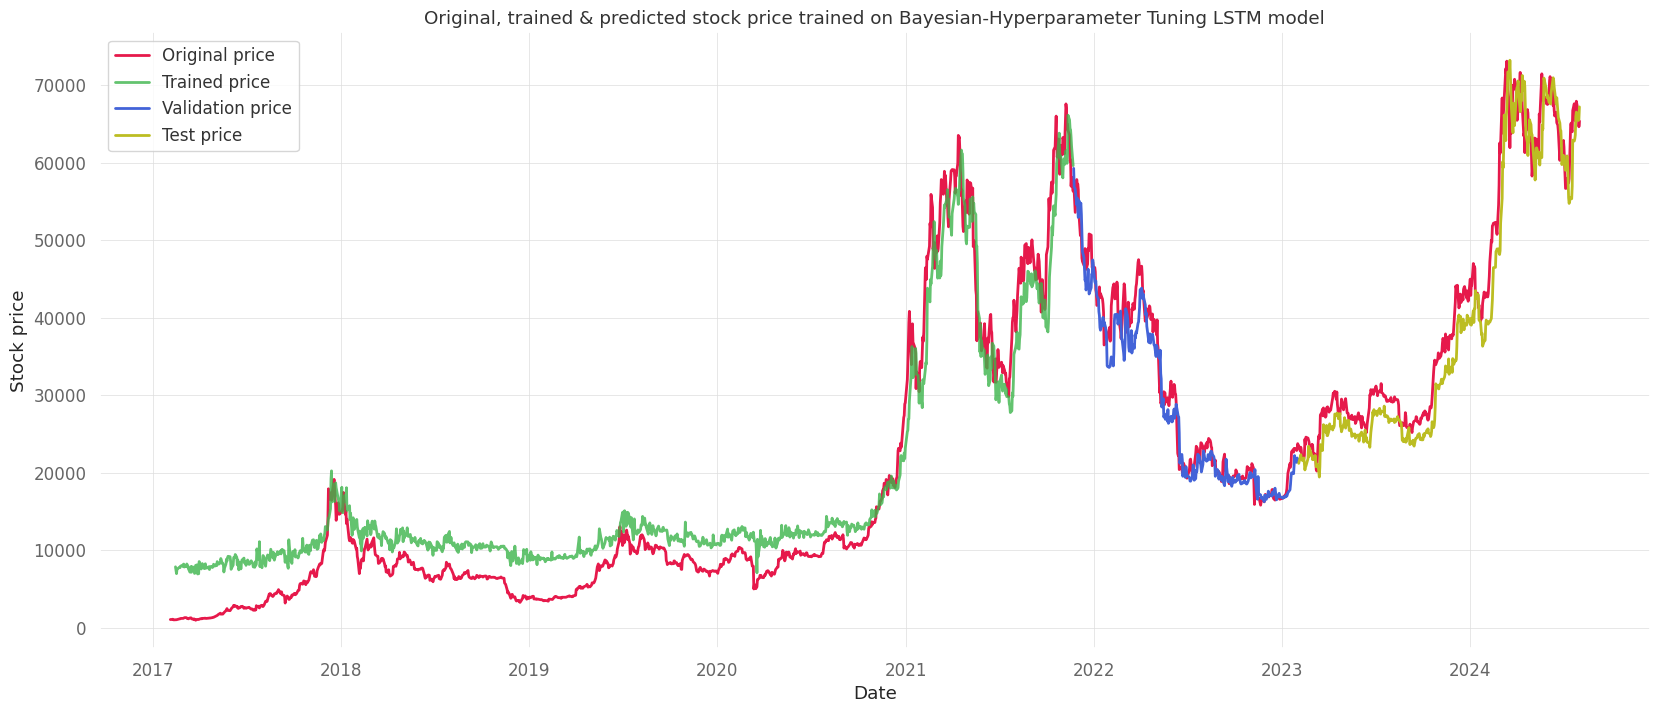

In [27]:
# Inspect and visualize test performance
bayesian_lstm_predictions = test_inspection(model_bayesian_lstm, X_test_scaled, y_test, 'Bayesian-Hyperparameter Tuning LSTM')
prediction_bayesian_lstm_df = final_visualization(btc_data_1, lookback, DATA_SPLIT_PCT, SEED, model_bayesian_lstm, X_train_scaled, X_valid_scaled, bayesian_lstm_predictions, btc_data_1[target_column], 'Bayesian-Hyperparameter Tuning LSTM')

# 4. BAYESIAN HYPER-PARAMETER TUNING BILSTM MODEL

The below code demonstrates the process of training BiLSTM model. Specifically, after defining input shape and output units, BiLSTM model is initialized, then its hyperparameters are tunned using Bayesian optimization. Finally, the best hyperparameters are applied to fit the BiLSTM model.

In [39]:
# Instantiate the HyperModel
hypermodel_BILSTM = BILSTMHyperModel(input_shape=input_shape, output_units=output_units)

# Bayesian Optimization
bayesian_bilstm_model = bayesian_opt_tuner(hypermodel_BILSTM, X_train_scaled, y_train, X_valid_scaled, y_valid)
history_bayesian_bilstm = fit_model(bayesian_bilstm_model, X_train_scaled, y_train, X_valid_scaled, y_valid)

The best hyperparameters are 
 {'bi_lstm_layer_1': 95, 'dropout_1': 0.30000000000000004, 'bi_lstm_layer_2': 67, 'dropout_2': 0.30000000000000004, 'learning_rate': 0.001}


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 5, 190)              │          77,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 5, 190)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 5, 134)              │         138,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 670)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 670)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 1)                   │             671 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 216,479 (845.62 KB)

 Trainable params: 216,479 (845.62 KB)

 Non-trainable params: 0 (0.00 B)

None


For consistent result, please load the trained model attached in the code submission.

In [43]:
# Step by step to reload the trained model
# Step 1: Save the trained model
#bayesian_bilstm_model.save('bayesian_bilstm_model_btc.keras')

# Step 2: Load the model
bayesian_bilstm_model = load_model('bayesian_bilstm_model_btc.keras')

# Step 3: Fit the model
history_bayesian_bilstm = fit_model(bayesian_bilstm_model, X_train_scaled, y_train, X_valid_scaled, y_valid)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step


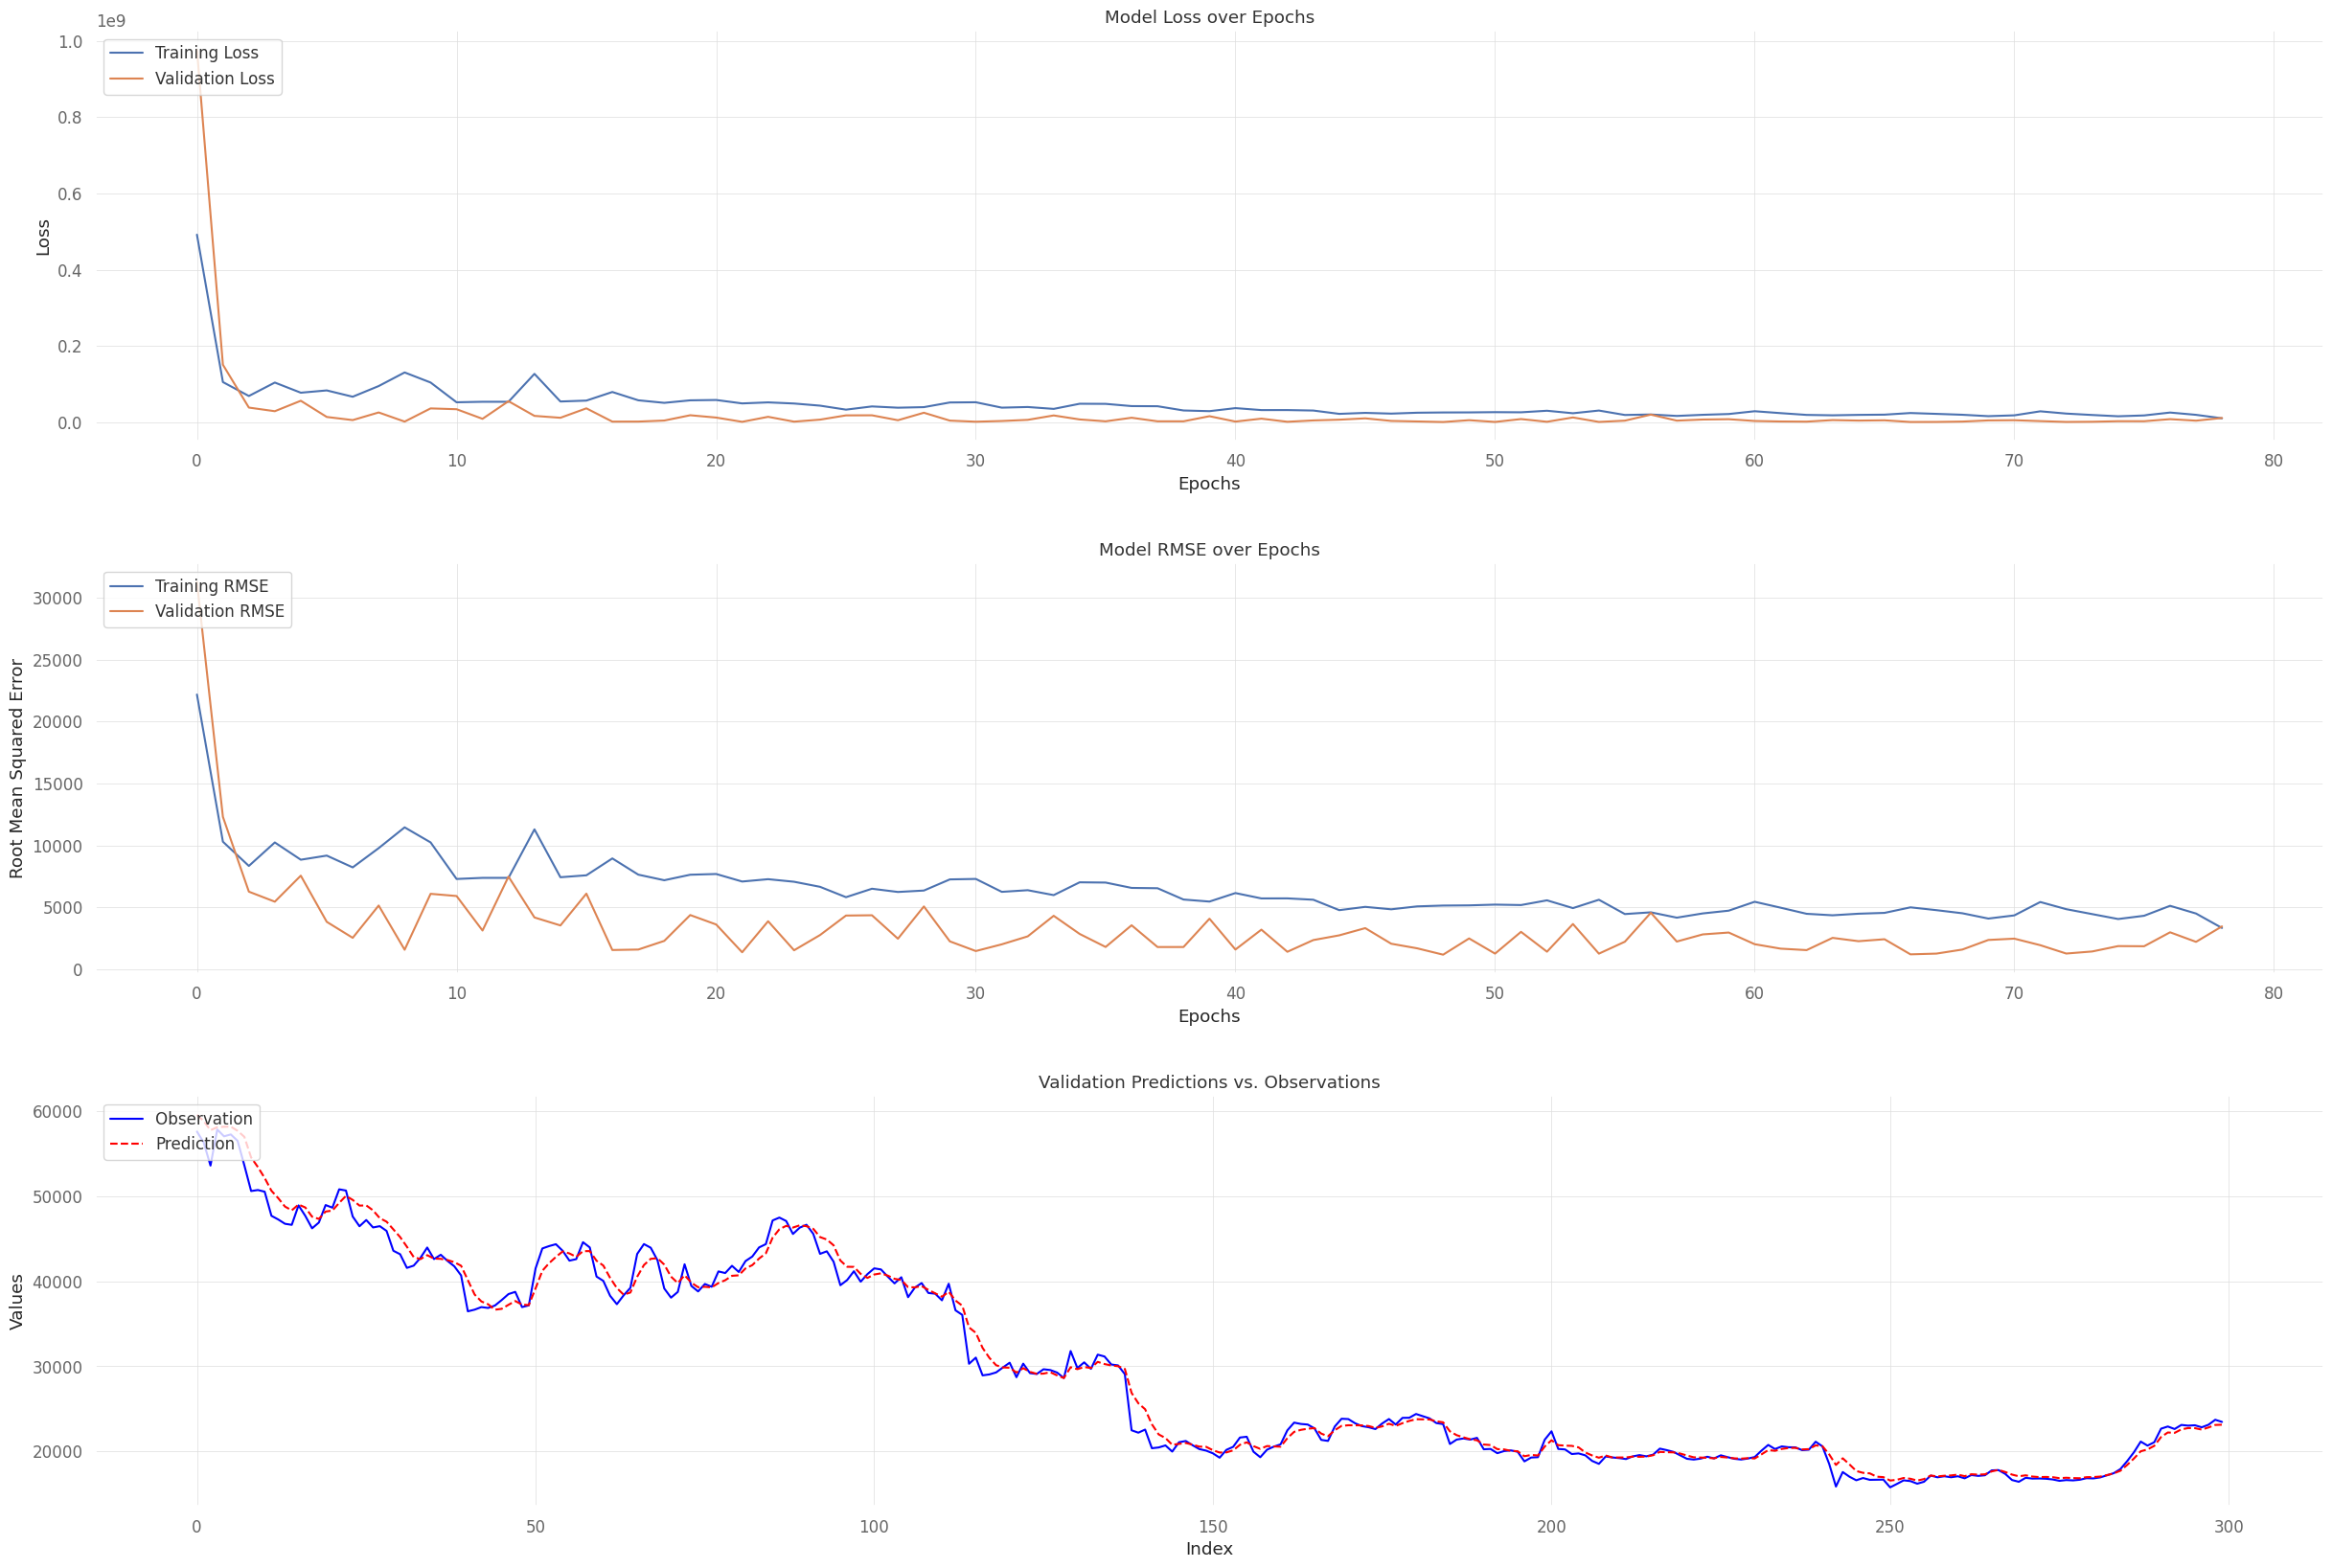

In [40]:
# Inspect performance on validation data
val_inspection(history_bayesian_bilstm, bayesian_bilstm_model, X_valid_scaled, y_valid)

In [44]:
# Check performance metrics
train_predict_bayesian_bilstm = bayesian_bilstm_model.predict(X_train_scaled)
valid_predict_bayesian_bilstm = bayesian_bilstm_model.predict(X_valid_scaled)
test_predict_bayesian_bilstm = bayesian_bilstm_model.predict(X_test_scaled)

bayesian_bilstm_train_mae, bayesian_bilstm_train_rmse= evaluate_prediction(train_predict_bayesian_bilstm, y_train, 'Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on train data')
bayesian_bilstm_valid_mae, bayesian_bilstm_valid_rmse = evaluate_prediction(valid_predict_bayesian_bilstm, y_valid, 'Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on valid data')
bayesian_bilstm_test_mae, bayesian_bilstm_test_rmse = evaluate_prediction(test_predict_bayesian_bilstm, y_test, 'Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on test data')

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on train data:
Mean Absolute Error: 15091.0625
Root Mean Square Error: 22877.2293

Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on valid data:
Mean Absolute Error: 13012.8136
Root Mean Square Error: 16667.7625

Evaluation result from Bayesian-Hyperparameter Tuning BILSTM on test data:
Mean Absolute Error: 18759.0679
Root Mean Square Error: 24217.8481



12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Out-of-sample R-squared: 0.99
Bayesian-Hyperparameter Tuning BILSTM:
Mean Absolute Error: 18759.0679
Root Mean Square Error: 24217.8481



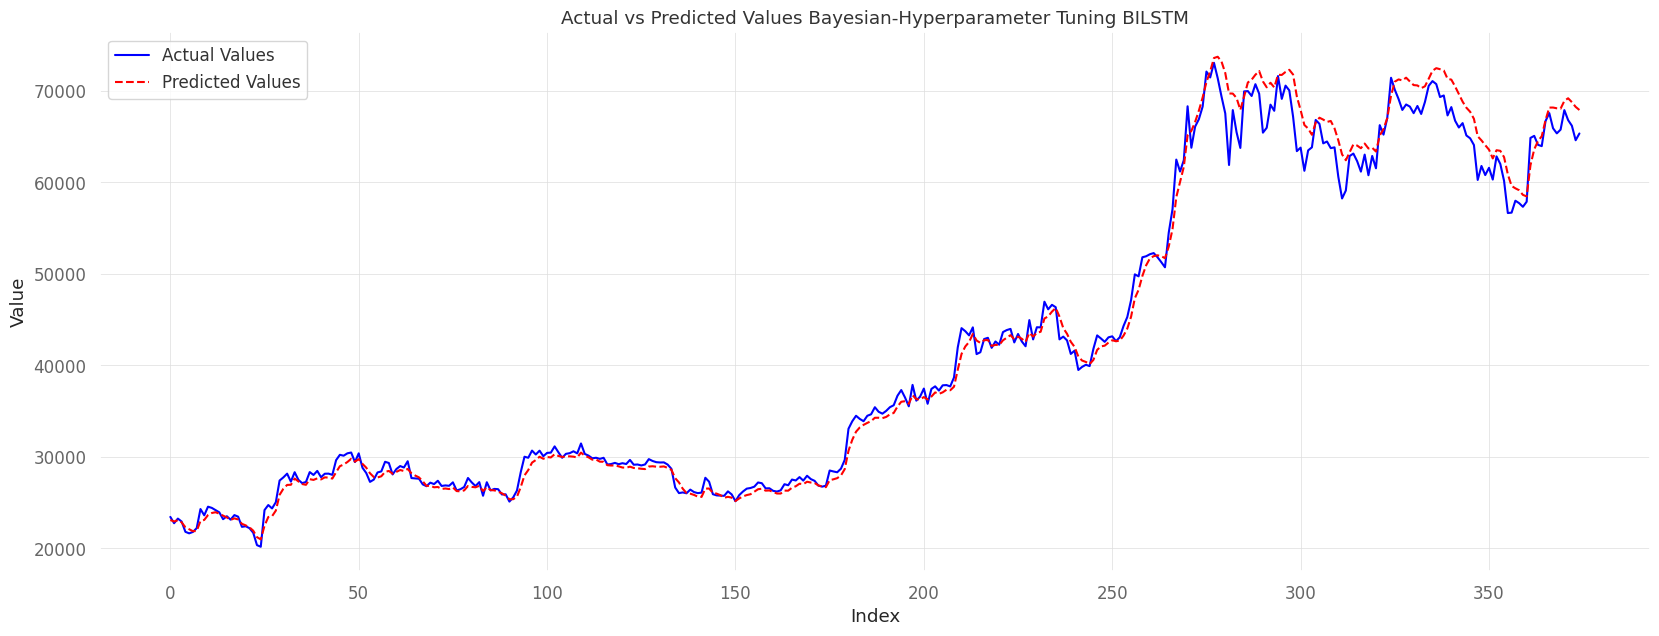

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


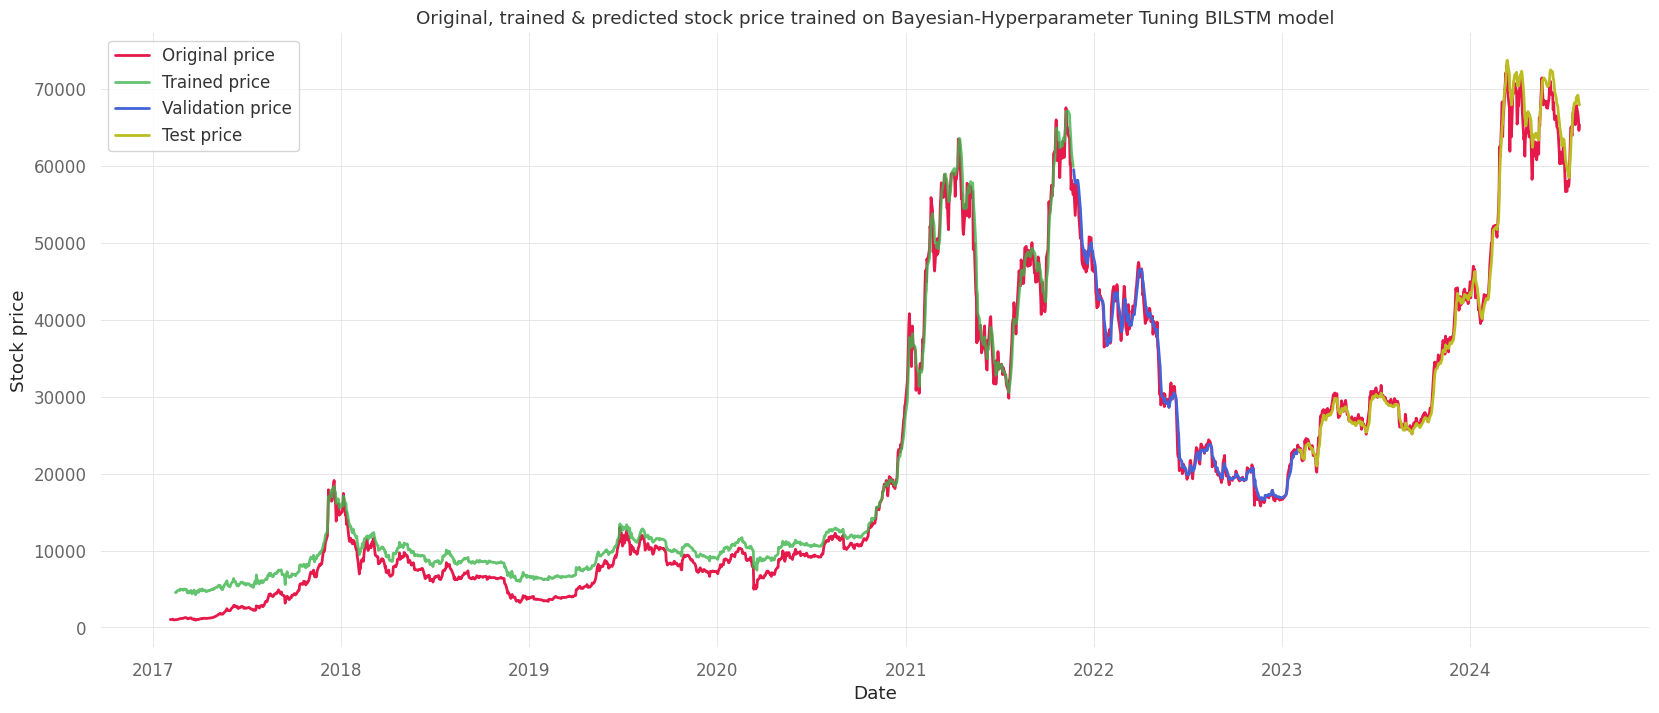

In [45]:
# Inspect and visualize test performance
bayesian_bilstm_predictions = test_inspection(bayesian_bilstm_model, X_test_scaled, y_test, 'Bayesian-Hyperparameter Tuning BILSTM')
prediction_bayesian_bilstm_df = final_visualization(btc_data_1, lookback, DATA_SPLIT_PCT, SEED, bayesian_bilstm_model, X_train_scaled, X_valid_scaled, bayesian_bilstm_predictions, btc_data_1[target_column], 'Bayesian-Hyperparameter Tuning BILSTM')

# 5. RESULT - LSTM & BILSTM

In [46]:
# Define model names
model_names = ['Bayesian_LSTM', 'Bayesian_BILSTM']

# Create a dictionary to store the results
results_dict = {
    'Train_MAE': [bayesian_lstm_train_mae, bayesian_bilstm_train_mae],
    'Train_RMSE': [bayesian_lstm_train_rmse, bayesian_bilstm_train_rmse],
    'Valid_MAE': [bayesian_lstm_valid_rmse, bayesian_bilstm_valid_mae],
    'Valid_RMSE': [bayesian_lstm_valid_rmse, bayesian_bilstm_valid_rmse],
    'Test_MAE': [bayesian_lstm_test_mae, bayesian_bilstm_test_mae],
    'Test_RMSE': [ bayesian_lstm_test_rmse, bayesian_bilstm_test_rmse],
    'R2-OOS': [0.94, 0.99]
}

# Display result
results_df = pd.DataFrame(results_dict, index=model_names)
results_df

Train_MAE    Train_RMSE     Valid_MAE    Valid_RMSE  \
Bayesian_LSTM    14655.838664  21588.296170  16073.114764  16073.114764   
Bayesian_BILSTM  15091.062523  22877.229279  13012.813614  16667.762506   

                     Test_MAE     Test_RMSE  R2-OOS  
Bayesian_LSTM    18640.114444  24022.513817    0.94  
Bayesian_BILSTM  18759.067851  24217.848126    0.99

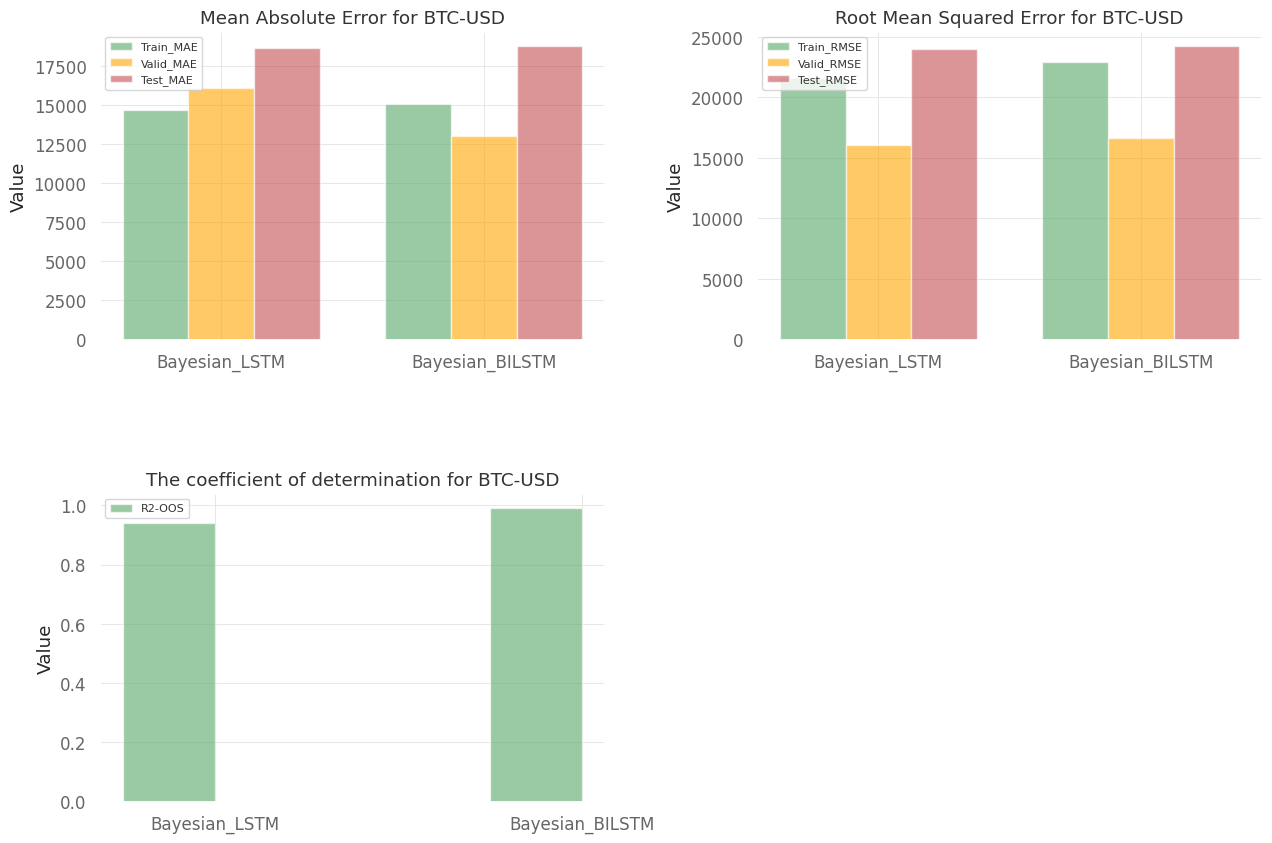

In [47]:
stock = 'BTC-USD'
x = np.arange(len(results_df))  # Get the positions for the bars
bar_width = 0.25  # Set the width of the bars

fig, axes = plt.subplots(2, 2, figsize=(15,10))  # Create a 2x2 grid for subplots

# Plot first subplot (MAE)
axes[0, 0].bar(x - bar_width, results_df['Train_MAE'], width=bar_width, label='Train_MAE', color='g', alpha=0.6)
axes[0, 0].bar(x, results_df['Valid_MAE'], width=bar_width, label='Valid_MAE', color='orange', alpha=0.6)
axes[0, 0].bar(x + bar_width, results_df['Test_MAE'], width=bar_width, label='Test_MAE', color='r', alpha=0.6)
axes[0, 0].set_title('Mean Absolute Error for {}'.format(stock))
axes[0, 0].set_ylabel('Value')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(results_df.index)
axes[0, 0].legend(loc='upper left', fontsize=8)

# Plot second subplot (RMSE)
axes[0, 1].bar(x - bar_width, results_df['Train_RMSE'], width=bar_width, label='Train_RMSE', color='g', alpha=0.6)
axes[0, 1].bar(x, results_df['Valid_RMSE'], width=bar_width, label='Valid_RMSE', color='orange', alpha=0.6)
axes[0, 1].bar(x + bar_width, results_df['Test_RMSE'], width=bar_width, label='Test_RMSE', color='r', alpha=0.6)
axes[0, 1].set_title('Root Mean Squared Error for {}'.format(stock))
axes[0, 1].set_ylabel('Value')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(results_df.index)
axes[0, 1].legend(loc='upper left', fontsize=8)

# Plot third subplot (R2-OOS)
axes[1, 0].bar(x - bar_width / 2, results_df['R2-OOS'], width=bar_width, label='R2-OOS', color='g', alpha=0.6)
axes[1, 0].set_title('The coefficient of determination for {}'.format(stock))
axes[1, 0].set_ylabel('Value')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(results_df.index)
axes[1, 0].legend(loc='upper left', fontsize=8)

# Remove the fourth subplot (empty)
fig.delaxes(axes[1, 1])  # Remove the last (empty) plot

# Adjust layout
plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Adjust the spacing between plots
plt.savefig('result_btc.png', dpi=300)
plt.show()


# 6. DISUSSION - STRATEGY vs. BENCHMARK



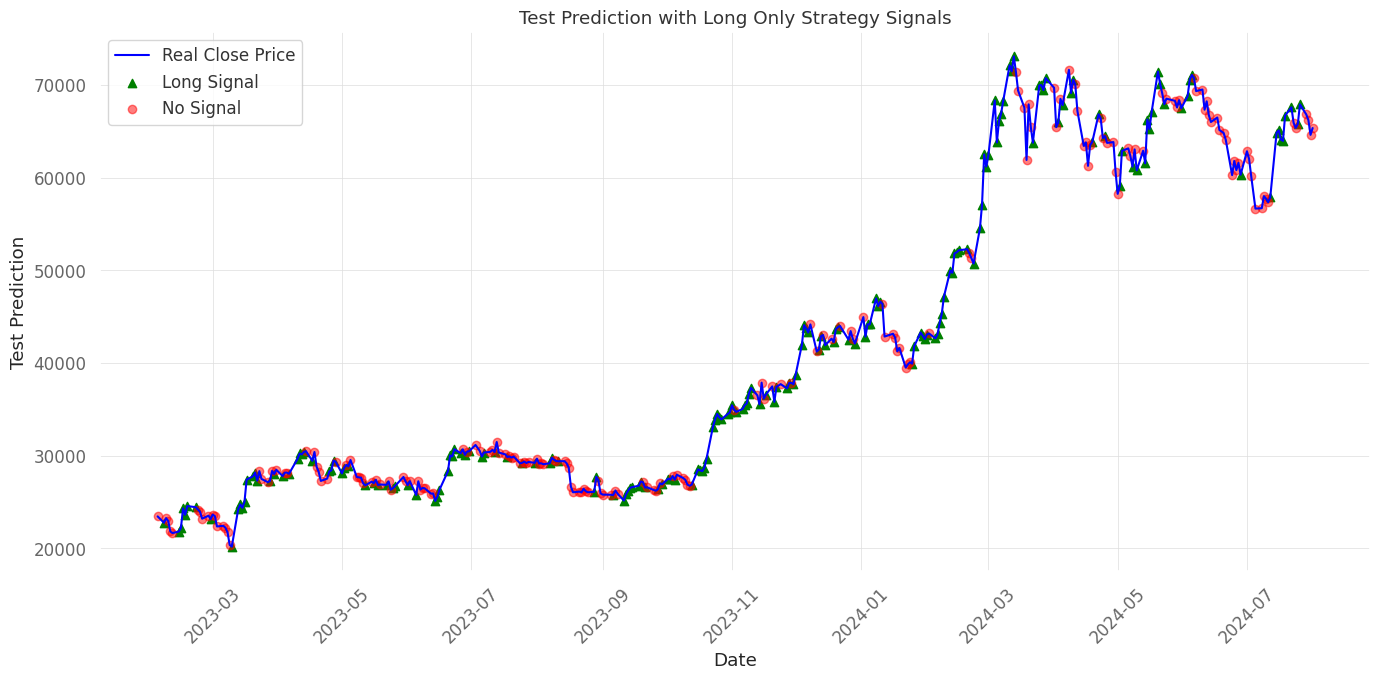

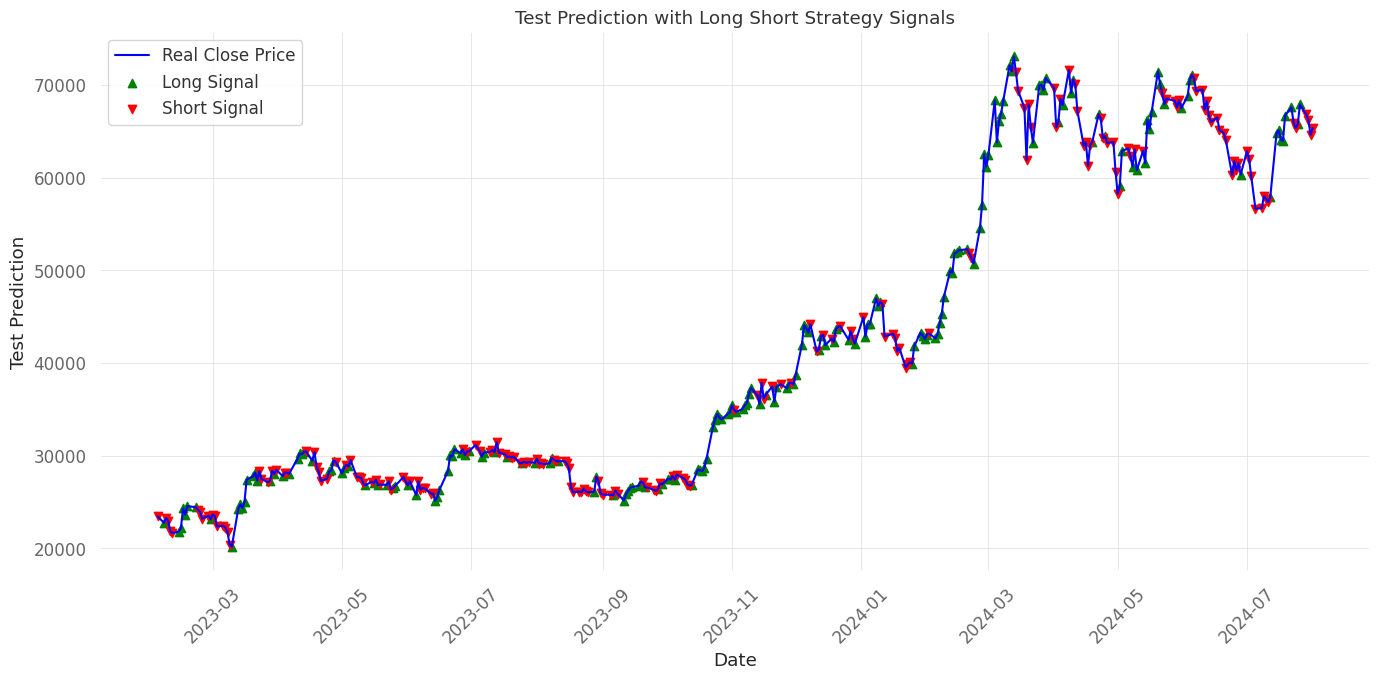

In [48]:
# Copying prediction results to a new DataFrame
df_prediction = prediction_bayesian_bilstm_df.copy()

# Long-Only
long_only_signal = generate_signals(df_prediction,'Test_Prediction',target='long_only')
df_prediction['Long_Only'] = long_only_signal['Strategy']

# Long-Short
long_short_signal = generate_signals(df_prediction,'Test_Prediction',target='long_short')
df_prediction['Long_Short'] = long_short_signal['Strategy']

# Buy-Hold
df_prediction['Observation'] = y_test
buy_hold_signal = generate_signals(df_prediction,'Observation',target='long_only')
df_prediction['Buy_Hold'] = buy_hold_signal['Strategy']

# Plot the proposed strategies
plot_strategy_signals(df_prediction,'Long Only', strategy='long_only')
plot_strategy_signals(df_prediction,'Long Short', strategy='long_short')

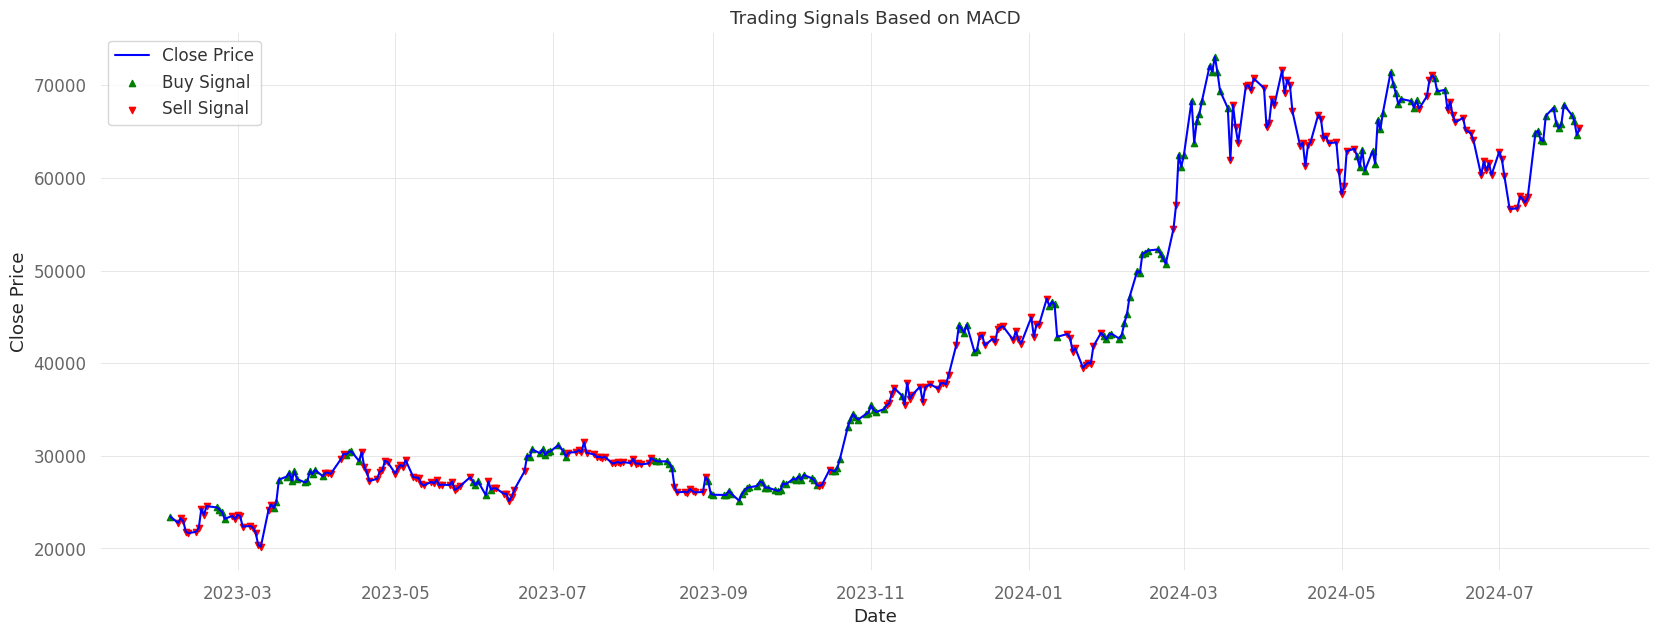

In [51]:
# Trading strategy based on MACD
# Align with prediction_df index
start_date = df_prediction.index[0]
end_date = df_prediction.index[-1]
filtered_df = btc_data[start_date:end_date]
macd_df = filtered_df[['Close','MACD_Line', 'MACD_Histogram', 'Signal_Line']].copy()

# Shift MACD_line and Signal_Line columns to align with the next time step
macd_df['MACD_line_prev'] = macd_df['MACD_Line'].shift(1)
macd_df['Signal_Line_prev'] = macd_df['Signal_Line'].shift(1)

# Apply the strategy logic
macd_df['MACD_Trading_Signal'] = 1
macd_df.loc[macd_df['MACD_line_prev'] >= macd_df['Signal_Line_prev'], 'MACD_Trading_Signal'] = 1
macd_df.loc[macd_df['MACD_line_prev'] < macd_df['Signal_Line_prev'], 'MACD_Trading_Signal'] = -1

# Drop the temporary columns used for calculation
macd_df.drop(columns=['MACD_line_prev', 'Signal_Line_prev'], inplace=True)

# Add to prediction df
df_prediction['MACD_Trading_Signal'] = macd_df['MACD_Trading_Signal']

# Plot MACD strategy
plot_technical_signals(macd_df, 'Close', 'MACD_Trading_Signal', 'MACD')

**CALCULATING PORTFOLIO VALUE OF EACH INDIVIDUAL STRATEGY**

In [52]:
# Portfolio Value of each individual strategy
df_portfolio_value = calculate_portfolio_values(df_prediction, start_money=1000)
df_portfolio_value

Return  Long_Only_Return  Long_Short_Return  \
2023-02-03  0.000000          0.000000          -0.000000   
2023-02-06 -0.029392         -0.029392          -0.029392   
2023-02-07  0.022152          0.000000          -0.022152   
2023-02-08 -0.013965         -0.000000           0.013965   
2023-02-09 -0.048840         -0.000000           0.048840   
...              ...               ...                ...   
2024-07-26  0.032456          0.032456           0.032456   
2024-07-29 -0.016082         -0.000000           0.016082   
2024-07-30 -0.009262         -0.000000           0.009262   
2024-07-31 -0.023893         -0.000000           0.023893   
2024-08-01  0.011425          0.000000          -0.011425   

            MACD_Trading_Return  Portfolio_Value_Buy_Hold  \
2023-02-03             0.000000               1000.000000   
2023-02-06             0.029392                970.608409   
2023-02-07            -0.022152                992.109314   
2023-02-08             0.013965                978.254219   
2023-02-09             0.048840                930.476319   
...                         ...                       ...   
2024-07-26             0.032456               2896.120482   
2024-07-29            -0.016082               2849.545642   
2024-07-30            -0.009262               2823.152621   
2024-07-31            -0.023893               2755.697980   
2024-08-01            -0.011425               2787.180766   

            Portfolio_Value_Long_Only  Portfolio_Value_Long_Short  \
2023-02-03                1000.000000                 1000.000000   
2023-02-06                 970.608409                  970.608409   
2023-02-07                 970.608409                  949.107504   
2023-02-08                 970.608409                  962.362066   
2023-02-09                 970.608409                 1009.363794   
...                               ...                         ...   
2024-07-26                8357.553636                20976.989786   
2024-07-29                8357.553636                21314.337611   
2024-07-30                8357.553636                21511.754960   
2024-07-31                8357.553636                22025.743366   
2024-08-01                8357.553636                21774.107746   

            Portfolio_Value_MACD_Trading  
2023-02-03                   1000.000000  
2023-02-06                   1029.391591  
2023-02-07                   1006.588522  
2023-02-08                   1020.645823  
2023-02-09                   1070.494128  
...                                  ...  
2024-07-26                    788.893636  
2024-07-29                    776.206803  
2024-07-30                    769.017432  
2024-07-31                    750.643011  
2024-08-01                    742.067204  

[375 rows x 8 columns]

**VISUALIZING THE PORTFOLIO VALUE**

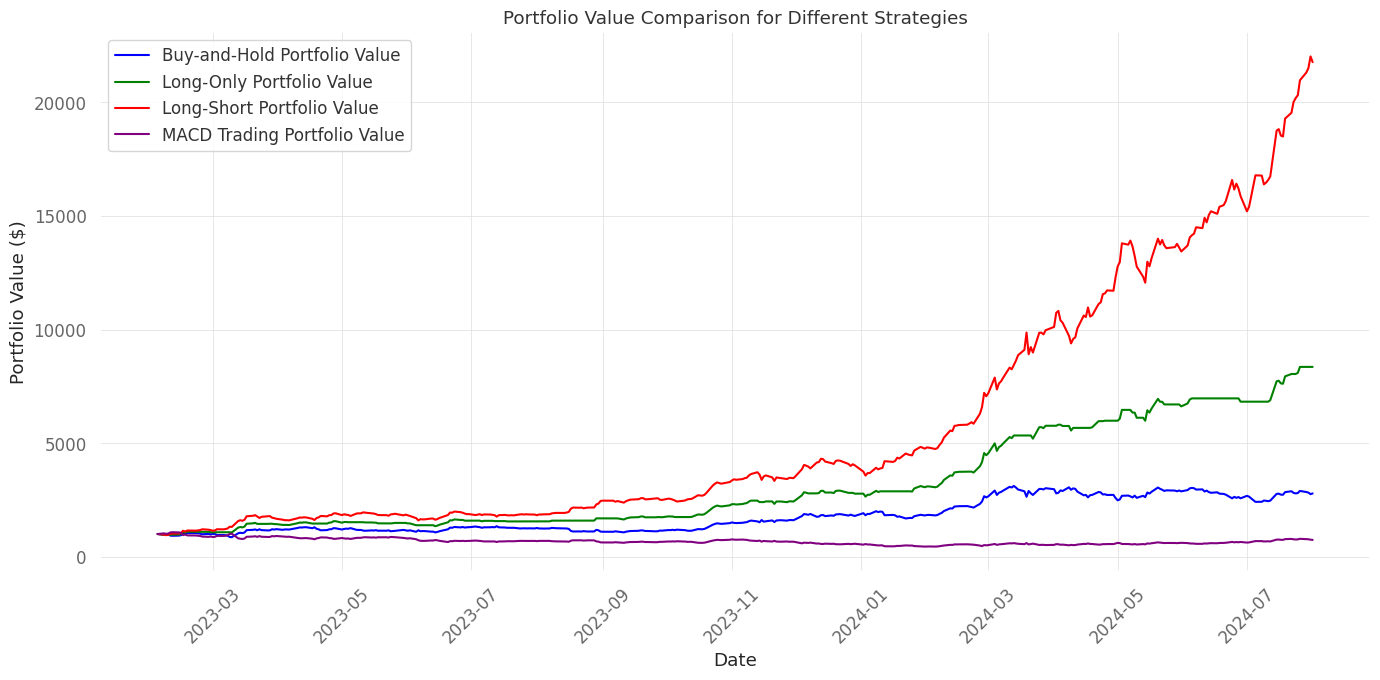

In [53]:
plot_portfolio_values(df_portfolio_value)

**FULL STATISTIC**

In [54]:
qs.reports.metrics(df_portfolio_value['Long_Only_Return'], benchmark = df_portfolio_value['Return'],mode="full")

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2023-02-03   2023-02-03
End Period                 2024-08-01   2024-08-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       51.0%

Cumulative Return          178.72%      735.76%
CAGR﹪                     60.63%       166.9%

Sharpe                     1.6          3.77
Prob. Sharpe Ratio         98.03%       100.0%
Smart Sharpe               1.55         3.66
Sortino                    2.82         10.1
Smart Sortino              2.73         9.79
Sortino/√2                 1.99         7.14
Smart Sortino/√2           1.93         6.92
Omega                      2.83         2.83

Max Drawdown               -22.47%      -14.03%
Longest DD Days            141          64
Volatility (ann.)          51.03%       39.93%
R^2                        0.64         0.64
Information Ratio          0.14         0.14
Calmar              

In [55]:
qs.reports.metrics(df_portfolio_value['Long_Short_Return'], benchmark = df_portfolio_value['Return'],mode="full")

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2023-02-03   2023-02-03
End Period                 2024-08-01   2024-08-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          178.72%      2,077.41%
CAGR﹪                     60.63%       315.57%

Sharpe                     1.6          4.45
Prob. Sharpe Ratio         98.03%       100.0%
Smart Sharpe               1.57         4.36
Sortino                    2.82         9.39
Smart Sortino              2.76         9.19
Sortino/√2                 1.99         6.64
Smart Sortino/√2           1.95         6.5
Omega                      2.27         2.27

Max Drawdown               -22.47%      -18.08%
Longest DD Days            141          52
Volatility (ann.)          51.03%       49.38%
R^2                        0.07         0.07
Information Ratio          0.14         0.14
Calmar           

In [56]:
qs.reports.metrics(df_portfolio_value['MACD_Trading_Return'], benchmark = df_portfolio_value['Return'],mode="full")

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2023-02-03   2023-02-03
End Period                 2024-08-01   2024-08-01
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       100.0%

Cumulative Return          178.72%      -25.79%
CAGR﹪                     60.63%       -12.88%

Sharpe                     1.6          -0.13
Prob. Sharpe Ratio         98.03%       43.61%
Smart Sharpe               1.49         -0.12
Sortino                    2.82         -0.18
Smart Sortino              2.62         -0.17
Sortino/√2                 1.99         -0.13
Smart Sortino/√2           1.85         -0.12
Omega                      0.98         0.98

Max Drawdown               -22.47%      -58.68%
Longest DD Days            141          536
Volatility (ann.)          51.03%       51.29%
R^2                        0.06         0.06
Information Ratio          -0.07        -0.07
Calmar    